<font size="5">**C. Forecasting delle TS con la Regressione**</font><br>

> (c) 2025 Antonio Piemontese

---

**Legenda icone (standard) usate nel notebook**:<br>
👉 punto di attenzione, il "succo"<br>
📌 nota<br>
📦 punto elenco importante<br>
📊 dati/numeri<br>
🔹 punto elenco normale<br>
⭐ punto elenco importante<br>
✅ punto risolto, positivo<br>
❌ punto negativo, da evitare<br>
⚠️ attenzione

---

Uno strumento di forecasting molto utilizzato, in generale, è la **regressione multi-variata**, anche quindi per serie temporali. Occorre avere dei **predittori** (quali valori precedenti della serie) affidabili per catturare <u>trend e stagionalità, che è l'ambito di questa sezione</u>.<br>

Si stima un **modello** dai dati disponibili (la serie temporale), che è <u>un'equazione di regressione stimata</u>; inserendo nell'equazione i valori dei predittori, essa prevede i valori futuri della serie (*forecasting*)

Vedremo <u>differenti tipi di trend</u>: 
* lineare;
* esponenziale;
* quadratico (un caso di polinomiale).

Considereremo <u>due tipi di stagionalità</u>:
* additiva;
* moltiplicativa.

Vedremo infine cos'è l'**auto-correlazione** (la correlazione tra valori vicini della serie) e come essa può aiutare a prevedere ancora meglio con la costruzione di un modello **auto-regressivo**, che è anche utile per valutare la capacità predittiva di una serie temporale (un *random walk*?).  

Useremo nuovamente il dataset dei viaggiatori Amtrak.

Vedi [qui](https://setosa.io/ev/ordinary-least-squares-regression/) per una **animazione della regressione** con la quale "giocare" per comprendere in modo intuitivo il funzionamento della regressione <u>a prescindere dalle serie temporali</u>.

# Import dei package richiesti

In [1]:
from pathlib import Path

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                       # per i grafici matplotlib (meglio di 'pylab')
import statsmodels.formula.api as smf                 # per specificare modelli statistici usando una sintassi simile a R, basata su formule               
from statsmodels.tsa import tsatools, stattools       # funzioni di supporto alla gestione di serie temporali 
from statsmodels.tsa.arima.model import ARIMA         # modello ARIMA
from statsmodels.graphics import tsaplots

import dmba

%matplotlib inline


# Fit OLS

Iniziamo ora una **serie di fit** con **differenti modelli di regressione OLS** (trend lineare, esponenziale, polinomiale, quadratico, con stagionalità.<br>
Come nel notebook *B. Gestione delle serie temporali* useremo la libreria `statsmodels.formula.api` e la funzione `smf.ols`.<br>
📌 A differenza del notebook *B. Gestione delle serie temporali*, <u>tuttavia</u>:
- useremo un approccio "ibrido" (quello del libro DMfBA v1, ancorchè sconsigliato da chatGPT5): costruzione della matrice di disegno con la funzione `add_trend` di `tsa.tsatools` e poi fit con la funzione `smf.ols` di `statsmodels.formula.api`
- il nome dei predittori temporali sarà `trend` e `np.square(trend)` e non `t` e `t2` (come nel notebook *B. Gestione delle serie temporali*)
- e soprattutto **divideremo** il dataset in training e test, faremo il fit dei modelli sul dataset di training e calcoleremo **l'RMSE di test "out-of-sample" (sui dati di test)**, che nel notebook *B. Gestione delle serie temporali* era invece stato calcolato solo con i metodi *naive forecast* e *seasonal naive forecast* (e non con la regressione OLS, per la quale si era fatto il fit sulla serie **intera**).

## Trend Lineare

[L'equazione](Trend_equations.png) modella solo il trend (in modo lineare); non c'è modellazione della stagionalità.

In [2]:
# caricamento dei dati e conversione in time series:
Amtrak_df = dmba.load_data('Amtrak.csv')
print(Amtrak_df.info())                                                 # la struttura del dataframe caricato
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')  # la conversione della data
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# come sempre:
print('\n',type(ridership_ts))        # una serie pandas
print('\n',ridership_ts)              # valori ed indice della serie
print('\n',ridership_ts.values)       # i valori della serie
print('\n',ridership_ts.index)        # il range dell'indice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      159 non-null    object 
 1   Ridership  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB
None

 <class 'pandas.core.series.Series'>

 Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, Length: 159, dtype: float64

 [1708.917 1620.586 1972.715 1811.665 1974.964 1862.356 1939.86  2013.264
 1595.657 1724.924 1675.667 1813.863 1614.827 1557.088 1891.223 1955.981
 1884.714 1623.042 1903.309 1996.712 1703.897 1810.    1861.601 1875.122
 1705.259 1618.535 1836.709 1957.043 1917.185 1882.398 1933.009 1996.167
 1672.841 1752.827 1720.377 1734

FIT di un modello lineare alla serie;
- attenzione --> NON si usa lo stimatore generico 'LinearRegression' (che non è specifico per TS);
- si usa una regressione lineare specifica PER le TS (time series), formita dalla libreria `statsmodels`

In [3]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')                  # 'ct' modella costante e trend lineare (vedi help);
ridership_lm = smf.ols(formula='Ridership ~ trend', data=ridership_df).fit() # ols=Ordinary Least Square
                             # attenzione: epsilon non modellato nella formula perchè si assume media(epsilon)=0;
                             # beta.0 anch'esso non modellato
print(ridership_df.head(10)) # le tre componenti modellate: le colonne 'ridership' (Yt), 'const' (beta-0) e 'trend' (t)';
                             # NON sono i coefficienti fittati!
print(type(ridership_lm))    # l'oggetto regressione creato;


            Ridership  const  trend
Date                               
1991-01-01   1708.917    1.0    1.0
1991-02-01   1620.586    1.0    2.0
1991-03-01   1972.715    1.0    3.0
1991-04-01   1811.665    1.0    4.0
1991-05-01   1974.964    1.0    5.0
1991-06-01   1862.356    1.0    6.0
1991-07-01   1939.860    1.0    7.0
1991-08-01   2013.264    1.0    8.0
1991-09-01   1595.657    1.0    9.0
1991-10-01   1724.924    1.0   10.0
<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>


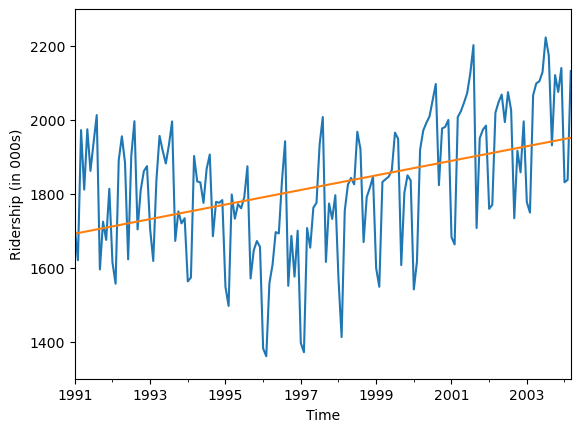

In [4]:
# plot della serie:
ax = ridership_ts.plot()
ridership_lm.predict(ridership_df).plot(ax=ax)  # --> attenzione, sono PSEUDO-previsioni, ovvero previsioni IN-SAMPLE  (perchè il metodo OLS è 
                                                # stato 'allenato' (trained) sull'INTERO dataset).
                                                # In altre parole, il training dataset è l'intero dataset e NON c'è
                                                # test/validation set (l'ambito nel quale si fanno le VERE previsioni)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()
                                       # --> è evidente da questo plot che il trend di questa serie NON è lineare, ma 
                                       #     invece a forma di U (U-shaped)).
                                       #     La linearità è comunque quasi sempre la prima opzione da verificare.

Ora, **partizioniamo** i dati in training e test/validazione.

In [5]:
# Partizionamento dei dati (come già visto nello script B.):
nValid = 36   # sempre IN CODA nelle TS (a differenza della regressione per dati cross-sezionali, dove il validation
              # set è in genere CAMPIONATO casualmente, senza rimpiazzo)
nTrain = len(ridership_ts) - nValid
train_df = ridership_df[:nTrain]   # i primi 123 mesi della serie
valid_df = ridership_df[nTrain:]   # gli ultimi 36 mesi della serie
print(len(train_df));print(len(valid_df))  # la lunghezza in mesi dei due set

123
36


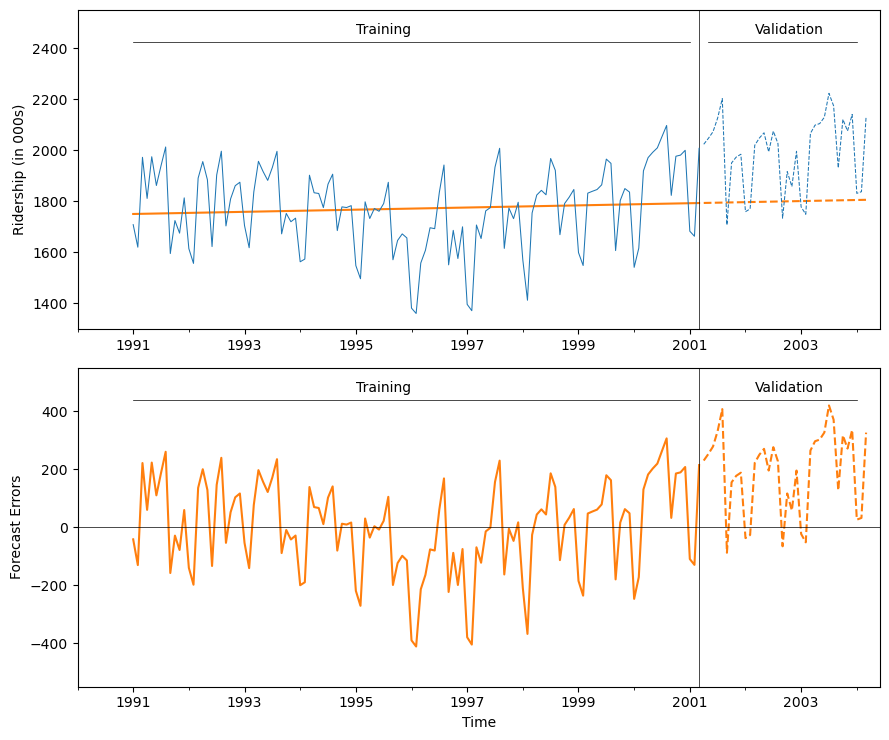

In [6]:
# Fit LINEARE sul training set e previsione del validation set [con un unico comando: solo sm.ols]:
ridership_lm = smf.ols(formula='Ridership ~ trend', data=train_df).fit()  # la fit (il primo passo)
predict_df = ridership_lm.predict(valid_df)

# Creazione del grafico matplotlib.
# Note:
# - prima la definizione delle 2 funzioni di creazione materiale del grafico, poi il corpo centrale della cella.
# - C0, C1, C2 sono codifiche di colori;

# la definizione della funzione di creazione materiale del singolo sotto-grafico (per gli aspetti ad esso specifici):
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

# la definizione della funzione di creazione materiale del DOPPIO grafico (per gli aspetti comuni ad entrambi)
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()
    # per assicurarsi che entrambi gli assi abbiano lo stesso range in ascissa
    xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), 
            max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
    axes[0].set_xlim(*xlim)
    axes[1].set_xlim(*xlim)

# il corpo centrale della cella (il suo MAIN):
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')                      # metodo di 'predict' sul train set.
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')  # metodo di 'predict' sul val. set
    
residual = train_df.Ridership - ridership_lm.predict(train_df)   # i 'residui' sul training set
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)   # i 'residui' sul validation set
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)                            # il richiamo della funzione di creazione grafico

plt.tight_layout()                     # migliora l'aspetto del grafico complessivo; vedi stackoverflow 9603230 

plt.show()                             # fa tante cose, interagisce con il SO, visualizza; 
                                       # da eseguire solo una volta per cella!

    
                                       # --> primpo plot: i valori effettivi (in blu continuo), fittati (in arancione) 
                                       #     e previsti noti (in blu tratteggiato);
        
                                       #     secondo plot: i residui (forecast errors)
                                       # --> sembra ragionevole assumerne media 0 (un'assunzione della regressione)

In [7]:
# i coefficienti stimati:    
ridership_lm.summary() # --> la parte importante è quella centrale 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Mon, 15 Sep 2025   Prob (F-statistic):              0.390
Time:                        23:17:28   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.000    1692.802    1807.917
trend          0.3514      0.407      0.864      0.390      -0.454       1.157
==============================================================================
Omnibus:                        4.293   Durbin-Watson:                   1.110
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.340
Skew:                          -0.435   Prob(JB):                        0.114
Kurtosis:                       2.700   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Non farsi intimidire da questo (troppo ricco?) sommario statistico! **[Qui](Sintesi_OLS.png) le metriche importanti**.<br><br>
I [coefficienti](https://it.wikipedia.org/wiki/Regressione_lineare) ed i [p-value](https://it.wikipedia.org/wiki/Valore_p#:~:text=In%20statistica%20inferenziale%2C%20in%20particolare,supposta%20vera%20l'ipotesi%20nulla.) riportati possono essere <u>fuorvianti</u>, come in questo caso! (anche se, comunque, il pvalue del trend è ben superiore al 5%).<br><br>
In questo caso, come già sappiamo, il fit lineare è **ragionevole, non il migliore!** (ce ne sono di più appropriati a questo caso, li vediamo adesso).<br><br>
Un fit inadeguato è spesso meglio visibile dal **plot dei residui**, che sempre si deve accompagnare all'esame dei coefficienti. I residui, in un buon fit, dovrebbero essere a media 0 e varianza costante.<br><br>
Che questo fit (lineare) non sia adeguato lo si vede anche dal cosiddetto [R quadro](https://it.wikipedia.org/wiki/Coefficiente_di_determinazione), che qui è molto basso (il 6 per mille).<br><br>
[***Residuo***](https://doc.arcgis.com/it/insights/latest/analyze/regression-analysis.htm#:~:text=I%20residui%20sono%20la%20differenza,hanno%20un%20valore%20residuo%20negativo.), anche detto *errore di forecast*, è ciò che non è spiegato dal modello.



Questo summary si riferisce al fit del modello sui dati di training (`ridership_lm`): non sappiamo ancora quale sia il RMSE dei dati di test (ancora da calcolare). Quindi non possiamo ancora confrontare la regressione lineare con il seasonal naive forecast (che NON ha R^2 perchè NON è un modello di regressione).

## Trend esponenziale
Una forma spesso usata per modellare le serie temporali è appunto quella <u>esponenziale</u>, che implica (assume!) un aumento / diminuizione dei valori della serie nel tempo di tipo **moltiplicativo**.<br><br>
[L'equazione](Trend_equations.png) può essere facilmente *linearizzata* con la funzione [logaritmo naturale](https://it.wikipedia.org/wiki/Logaritmo); il logaritmo è un esponente.<br><br>
Anche qui l'equazione modella solo il trend (in modo esponenziale o lineare logaritmico); non c'è modellazione della stagionalità.<br><br>
[I trend esponenziali sono usati spesso nella serie temporali delle **vendite**, dove l'effetto moltiplicativo è nella percentuale di crescita (*percentage growth*).]<br><br>

<u>Attenzione</u>: per confrontare GRAFICAMENTE i due fit (lineare ed esponenziale linearizzato) occorre plottare le due serie sulla **stessa scala** dell'ordinata. Poichè il fit lineare prevede le *Y* ed il fit esponenziale linearizzato prevede invece le *log(Y)*, quest'ultime devono essere **riconvertite a ritroso** con la funzione *exp* (che è l'inversa del logaritmo). 




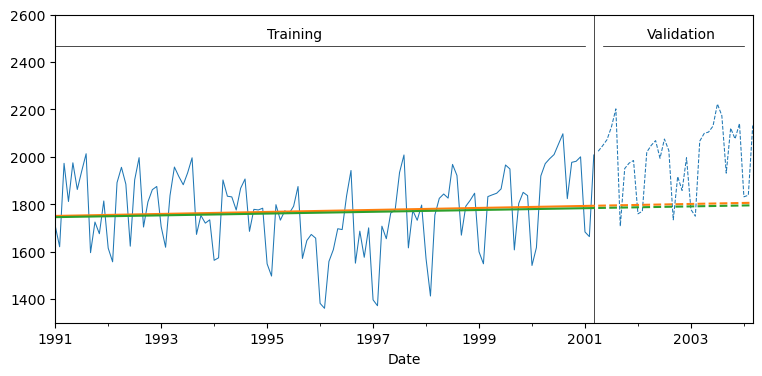

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(Ridership)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5707
Date:                Mon, 15 Sep 2025   Prob (F-statistic):              0.451
Time:                        23:17:28   Log-Likelihood:                 118.67
No. Observations:                 123   AIC:                            -233.3
Df Residuals:                     121   BIC:                            -227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4647      0.017    442.535      0.000       7.431       7.498
trend          0.0002      0.000      0.755      0.451      -0.000       0.001
==============================================================================
Omnibus:                        8.566   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.749
Skew:                          -0.652   Prob(JB):                       0.0126
Kurtosis:                       3.091   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# grazie appunto alla linearizzazione dell'equazione operata dalla funzione logaritmo è possibile applicare ai dati un fit 
# esponenziale, che NON è lineare, ed usare quindi la regressione lineare.

# NOTA: le funzioni lineari sono quelle che usano solo moltiplicazione per scalare e somma, cioè aX+bY+cZ (detta appunto
# 'combinazione lineare').
# Esempi di funzioni non-lineari: moltiplicazione o divisione tra variabili, sin, cos, exp, log, radquad, ecc.

# anche fit lineare (e plot) per confronto [con 1 unico comando: solo sm.ols]:
ridership_lm_linear = smf.ols(formula='Ridership ~ trend', data=train_df).fit() # per default, 'ols' LASCIA 
                                                                                # l'intercetta nella equazione (vedi
                                                                                # più avanti) anche se essa non è da
                                                                                # noi stata esplicitata nell'argomento
                                                                                # 'formula'.
predict_df_linear = ridership_lm_linear.predict(valid_df)

# il fit esponenziale [con 1 unico comando: solo sm.ols]:
ridership_lm_expo = smf.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit() # --> 'np.log' per trasformare la Y!
predict_df_expo = ridership_lm_expo.predict(valid_df)

# la costruzione del grafico:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
train_df.plot(y='Ridership', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)
ridership_lm_linear.predict(train_df).plot(color='C1')
ridership_lm_linear.predict(valid_df).plot(color='C1', linestyle='dashed')
ridership_lm_expo.predict(train_df).apply(lambda row: math.exp(row)).plot(color='C2') # 'exp' per avere la stessa scala
ridership_lm_expo.predict(valid_df).apply(lambda row: math.exp(row)).plot(color='C2', #   "           "
                                                                          linestyle='dashed')

ax.get_legend().remove()

plt.show()
                                      # --> trend lineare in arancione;
                                      #     trend esponenziale linearizzato in verde;
                                      #     sono molto, molto SIMILI! --> NON c'è un fenomeno moltiplicativo 
                                      #     in questo dataset!

ridership_lm_expo.summary()           # --> sintesi statistica del fit esponenziale:
                                      #     - R-quadro uguale a prima;
                                      #     - coefficienti stimati completamente diversi dal fit lineare perchè la Y
                                      #       qui logaritmica!

         

In [9]:
print(math.exp(7.4647))                    # annullamento dellogaritmo tramite la sua funzione inversa che è l'esponente
print(train_df['Ridership'].values.mean()) # da capire

1745.3318701133592
1772.1446016260163


## Trend polinomiale (quadratico)
Un'altra forma di trend che è facile da modellare con la regressione lineare è quella polinomiale, che può essere *quadratica* (una parabola concava o convessa) oppure *cubica* (una curva sia concava che convessa). Polinomi maggiori del terzo grado sono usati di rado, ad es. per modellare fenomeni trigonometrici.<br><br>
Poichè già sappiamo che la forma della serie *Amtrak* è ad U, l'equazione quadratica sembra essere <u>la più adatta al fit, in questo caso</u>.<br><br>
La forma quadratica aggiunge all'[equazione](Trend_equations.png) un nuovo termine: <u>il trend al quadrato</u>.<br><br>
**Notare che l'equazione polinomiale (quadratica) è lineare nei coefficienti da stimare (i *beta.i*) ! E dunque si può usare il metodo di ML della regressione lineare!** Un esempio di equazione effettivamente non-lineare (nei coefficienti) era quella esponenziale <u>originaria</u>.

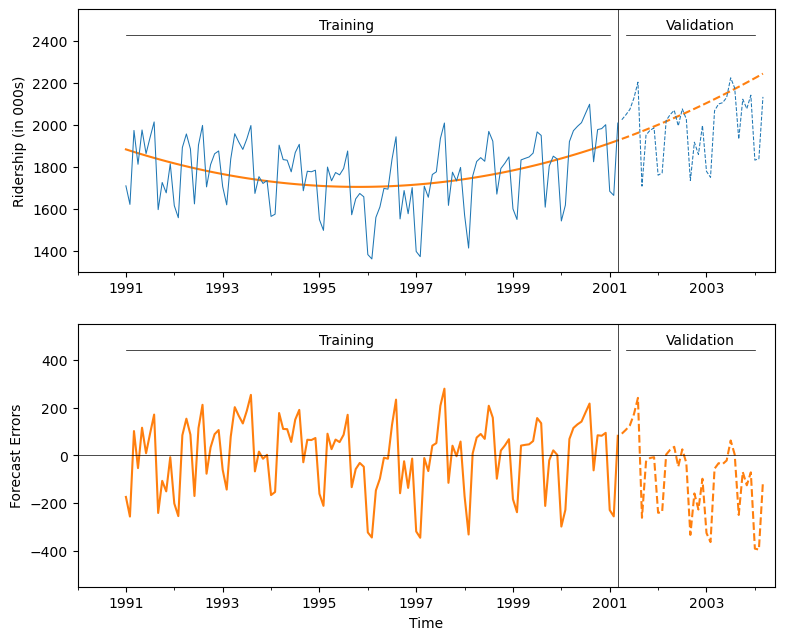

In [10]:
# Con il package 'statsmodels' possiamo fittare un modello quadratico in due modi alternativi [DMBA-python, p. 429]:
# - con il metodo 'add_trend('ctt'), come già visto;
# - oppure semplicemente usando nell'argomento 'formula' di 'sm.ols' la funzione np.square(trend) --> 1 solo statement!

ridership_lm_poly = smf.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_poly.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_poly.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')


  
residual = train_df.Ridership - ridership_lm_poly.predict(train_df)
                           # definendo in questo modo il residuo (actual - prediction) eventuali sovra-stime del
                           # valore t+k determineranno un residuo negativo.
                           # l'ordine dei sottraendi del residuo NON ha importanza, comunque.
            
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_poly.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)


plt.show()                   # --> primo plot: valori fittati, previsti ed effettivi;
                             #     secondo plot: i residui (forecast errors)
    
                             # --> Il fit quadratico del trend è quello migliore (dei tre esaminati).
                             #     Anche se il trend nella parte di validazione sembra sovra-stimato.
            
                             # Come si vede dal secondo plot, gli errori (residui) sono ora privi di trend (tutto 
                             # catturato, cioè spiegato, dall'equazione) e mostrano solo la stagionalità, 
                             # non modellata, e l'errore casuale.

In [11]:
# per conferma numerica:
ridership_lm_poly.summary()           # --> sintesi statistica del fit quadratico:
                                      #     - R-quadro cresciuto (ma manca ancora la stagionalità!);
                                      #     - tutti e tre i coefficienti significativi (p.value al 95% inferiore a 0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     10.58
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           5.84e-05
Time:                        23:17:28   Log-Likelihood:                -788.33
No. Observations:                 123   AIC:                             1583.
Df Residuals:                     120   BIC:                             1591.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1888.8840     40.915     46.166      0.000    1807.875    1969.893
trend               -6.2978      1.523     -4.134      0.000      -9.314      -3.282
np.square(trend)     0.0536      0.012      4.506      0.000       0.030       0.077
==============================================================================
Omnibus:                        7.384   Durbin-Watson:                   1.298
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.185
Skew:                          -0.540   Prob(JB):                       0.0275
Kurtosis:                       2.516   Cond. No.                     2.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**<u>Sintesi sulla forma del trend**</u>:
* in teoria, si può usare <u>qualsiasi</u> forma matematica dell'equazione della regressione lineare (semprechè il software la supporti);<br>
* attenzione: scegliere una forma significa assumere che essa sia valida <u>sia per il passato che per il futuro</u>, che è tutt'altro che scontato, in particolare se ci sono stati eventi *disrupting*;
* in pratica, si consiglia di non complicare l'equazione mai troppo, altrimenti si corre il rischio di [overfitting](https://it.wikipedia.org/wiki/Overfitting), un fenomeno molto frequente nella analisi e previsione delle serie temporali, nel quale **l'equazione (troppo complessa) si adatta bene ai dati di training (*fit*) ma non generalizza bene a nuovi dati (quelli futuri da prevedere)**. In termini tecnici, si dice che l'overfitting scambia il rumore per segnale;
* l'overfitting è misurabile con <u>*l'errore di previsione (RMSE)* sul validation set</u> (validation-RMSE >> training-RMSE) --> vedi più avanti; 
* inoltre un'equazione complessa è anche **meno intuitiva** e quindi più **difficile da spiegare** ai nostri utenti / committenti. 

Infine, calcoliamo RMSE del modello polinomiale (`ridership_lm_poly`), quello dei tre esaminati prima che esibisce le migliori metriche di fitting (R^2 e pvalue).

In [12]:
# ecco come si calcola l'errore di previsione (RMSE):
from sklearn.metrics import mean_squared_error   # RMSE non è direttamente disponibile

y_pred_train = ridership_lm_poly.predict(train_df).values  # previsioni sul training
y_pred_valid = ridership_lm_poly.predict(valid_df).values  # previsioni sul validation

y_actual_train = train_df['Ridership'].values   # actual del training
y_actual_valid = valid_df['Ridership'].values   # actual del validation

MSE = mean_squared_error(y_true=y_actual_train,y_pred=y_pred_train)  # MSE calcolato con scikit-learn sul training set
RMSE = math.sqrt(MSE)
print("Root Mean Square Error (training set): ",round(RMSE,2))

MSE = mean_squared_error(y_true=y_actual_valid,y_pred=y_pred_valid)  # MSE calcolato con scikit-learn sul validation set
RMSE = math.sqrt(MSE)
print("Root Mean Square Error (validation set): ",round(RMSE,2))

                     # --> come spesso capita, RMSE del training set è minore del RMSE del validation set;
                     # un bene? no, spesso avviene così. A noi interessa solo e soltanto il validation-RMSE, che
                     # è l'unico a fornire indicazione numerica ed oggettiva della qualità predittiva del modello.
                     # la differenza tra training-RMSE e validation-RMSE può essere utile come SPIA di overfitting,
                     # e quindi di un modello troppo complesso.

Root Mean Square Error (training set):  146.98
Root Mean Square Error (validation set):  179.85


Con sorpresa (?) il RMSE di test del modello quadratico (con il solo trend, senza la stagionalità) è **molto maggiore** di quello del seasonal naive forecast (circa 95!), visto nel notebook precedente (95 circa). Come si poteva evincere peraltro dal grafico dei residui di prima.

## Regressione con stagionalità
La stagionalità di una serie significa che i valori che appartengono ad una certa *stagione* della serie sono <u>costantemente più alti o più bassi</u> di quelli degli altri valori di ogni stagione.<br>
Esempi comuni sono: pattern settimanali (es. traffico), pattern mensili (es. fatture fine-mese), pattern trimestrali (es. tasse).<br>
La serie *Amtrak*, come visto, mostra forte stagionalità mensile (estiva).<br>
In un modello di regressione, la stagionalità è *catturata* (modellata, spiegata) creando una <u>nuova</u> variabile categorica (aka, qualitativa) che denota la stagione (il mese, qui) di ogni valore. Poichè la regressione in sè non può lavorare con predittori non-numerici, questa variabile categorica deve poi essere trasformata in una serie di variabili **binarie** (anche dette, *dummy variables*), tante quanti sono i valori distinti della variabile - 1.<br>
Cioè, qui creiamo una variabile categorica *mese* di 12 possibili valori che poi dobbiamo trasformare in 12-1 = 11 variabili binarie [12 variabili binarie provocherebbero [*multicollinearità*](https://en.wikipedia.org/wiki/Multicollinearity) con l'intercetta, che normalmente nella regressione è messa ad 1].<br>
La regola è **n-1** variabili binarie dove *n* è il numero di cicli (in questo caso i mesi).

Ora modelliamo la sola stagionalità senza il trend.

In [13]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c') # il trend NON è qui modellato ('c' è solo la costante);

ridership_df['Month'] = ridership_df.index.month           # la nuova variabile categorica;
                                                           # è una parte dell'indice della serie.

# il solito partizionamento dei dati:
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

# il fit lineare sui dati di training --> vedi C(Month) che automaticamente crea le 11 variabili binarie di 'Month':
ridership_lm_season = smf.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

print(ridership_lm_season.fittedvalues)  # i valori fittati (previsti) per il training set;
                                         # per vedere la lista di output fornita dallo stimatore, posizionarsi dopo 
                                         # l'oggetto creato dal metodo 'fit' e premere tab.
        
print('\n',ridership_lm_season.resid)    # i residui (non spiegati) per il training set

Date
1991-01-01    1573.972182
1991-02-01    1531.042000
1991-03-01    1834.739909
1991-04-01    1819.064100
1991-05-01    1852.194400
                 ...     
2000-11-01    1766.327400
2000-12-01    1804.387300
2001-01-01    1573.972182
2001-02-01    1531.042000
2001-03-01    1834.739909
Length: 123, dtype: float64

 Date
1991-01-01    134.944818
1991-02-01     89.544000
1991-03-01    137.975091
1991-04-01     -7.399100
1991-05-01    122.769600
                 ...    
2000-11-01    215.080600
2000-12-01    195.765700
2001-01-01    109.175818
2001-02-01    132.362000
2001-03-01    173.188091
Length: 123, dtype: float64


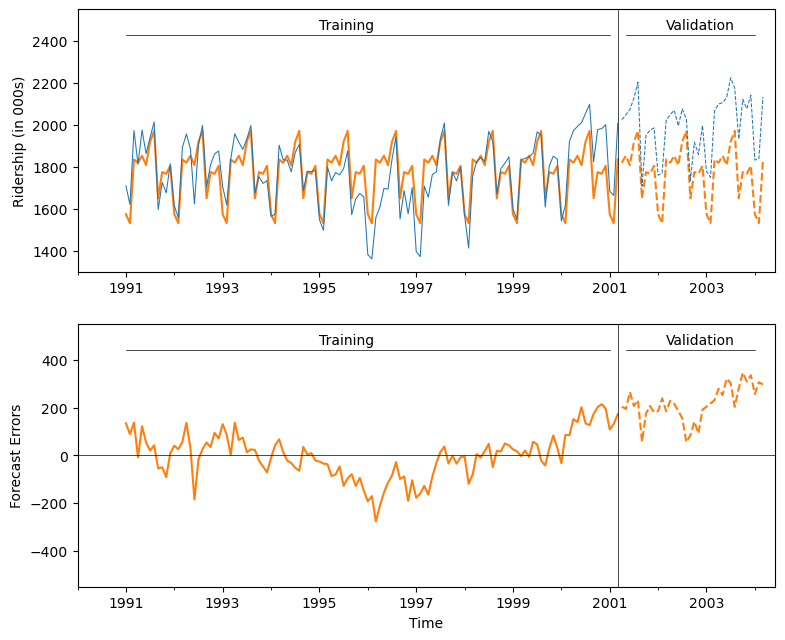

In [14]:
# le impostazioni generali del plot:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

# il plot delle previsioni sia sul training set che sul validation set:
ridership_lm_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

# il plot dei residui sia del training set che del validation set:
residual = train_df.Ridership - ridership_lm_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()
                                  # --> in blu i valori effettivi, in arancione i valori fittati.
                                  #     si vede ad occhio che sono modellati solo le stagionalità e non il trend

In [15]:
print(ridership_lm_season.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.20e-19
Time:                        23:17:28   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.

Il modello sembra catturare bene la stagionalità della serie (**R-quadro è molto aumentato**). Comunque <u>non cattura il trend</u>, che NON è stato modellato infatti. Questo è il motivo per il quale i residui hanno una <u>forma ad U</u>.<br><br>
La stagionalità così catturata è *additiva*, cioè: il valore medio di Y in una <u>certa </u> 'stagione' è fisso (più alto o meno alto rispetto alla stagione di riferimento). Ad esempio (per Amtrak): **C(Month)[T.8] = 396.66** significa che questo è l'aumento medio di passeggeri in agosto rispetto a gennaio (che è la *baseline*, cioè il valore di riferimento, ovvero il 12-o mese non tradotto in dummy variable). La stagionalità *moltiplicativa* (qui non presente, sembrerebbe) è modellata semplicemente con **log(Y)** nell'equazione, come già visto con il trend esponenziale.

## Regressione con trend (quadratico) e stagionalità
Infine, possiamo creare modelli che catturino **sia il trend che la stagionalità**.<br>
Dall'esame visivo della serie *Amtrak*, come sappiamo, sembrano essere presenti sia un trend quadratico che una stagionalità mensile.<br>
Abbiamo dunque bisogno di un modello di regressione con **13 predittori**: trend, trend al quadrato e 11 variabili binarie.

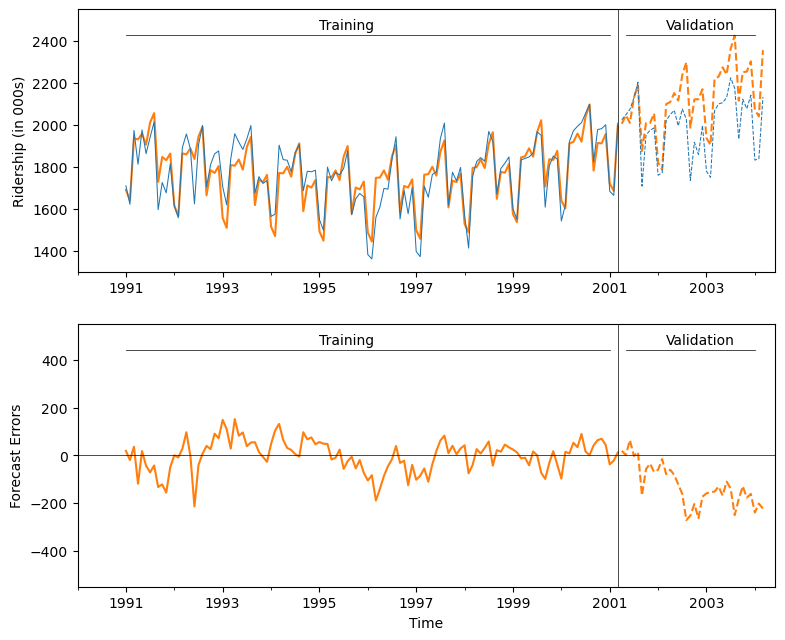

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           3.75e-35
Time:                        23:17:29   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

In [16]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')  # per definire la presenza del trend (di grado 1)
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_trendseason = smf.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_trendseason.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_trendseason.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()

print(ridership_lm_trendseason.summary())

                             # R-quadro è ancora salito!

**Bottom line**<br>
Calcolo dell'RMSE di questo modello sui dati di test.

In [17]:
y_pred_train = ridership_lm_trendseason.predict(train_df).values  # previsioni sul training
y_pred_valid = ridership_lm_trendseason.predict(valid_df).values  # previsioni sul validation

y_actual_train = train_df['Ridership'].values   # actual del training
y_actual_valid = valid_df['Ridership'].values   # actual del validation

MSE = mean_squared_error(y_true=y_actual_train,y_pred=y_pred_train)  # MSE calcolato con scikit-learn sul training set
RMSE = math.sqrt(MSE)
print("Root Mean Square Error (training set): ",round(RMSE,2))

MSE = mean_squared_error(y_true=y_actual_valid,y_pred=y_pred_valid)  # MSE calcolato con scikit-learn sul validation set
RMSE = math.sqrt(MSE)
print("Root Mean Square Error (validation set): ",round(RMSE,2))

Root Mean Square Error (training set):  66.76
Root Mean Square Error (validation set):  153.25


--- 

RMSE validation continua ad essere maggiore (e di molto) di quello del seasonal naive forecast (circa 95).<br>
Dipende dai residui negativi (vedi il plot di prima).<br>
Per ridurre RMSE del validation occorre aggiustare il trend, che è in eccessiva crescita.

---

Come sempre nel Machine Learning, una volta trovato il modello migliore, quello che spiega meglio il validation set, il modello è *riallenato (re-learning)* **sull'intero dataset (training + validation set)**, per utilizzare tutti i dati disponibili, ed è utilizzato quindi per il suo <u>scopo finale</u>: prevedere **nuovi valori della serie (per indici temporali *t+k*)**, cioè OLTRE ancora il validation set.

# Autocorrelazione e modelli *Arima*
* i modelli di regressione, anche quelli specifici per le TS, non tengono conto della **dipendenza (correlazione)** <u>tra gli elementi della serie</u>, che nei dati cross-sezionali (cioè senza indici temporali) è in genere **assente**;
* nelle serie temporali, invece, i valori della serie tra loro **vicini** tendono ad essere <u>correlati</u>; si chiama **auto-correlazione**; essa fornisce informazioni ed è utile per meglio prevedere i prossimi valori della serie;
* auto-correlazione *positiva*: valori alti tendono ad essere seguiti da valori alti;
* auto-correlazione *negativa*: valori alti tendono ad essere seguiti da valori bassi;

## Calcolo dell'auto-correlazione e plot ACF
La auto-correlazione (lineare, cioè di Pearson) si calcola **tra due vettori (serie)**: quella <u>originale</u> e quella <u>spostata in avanti</u> di K elementi, detta *k-lagged*.<br>

Si parla di *auto*-correlazione perchè i due vettori provengono dalla **stessa** serie.<br>

La serie **lag-1** è quella formata da tutti gli elementi della serie originale <u>spostati in avanti di 1 giorno</u>. L'**auto-correlazione lag-1** è quella tra la serie originale (ovviamente privata del primo periodo) e la serie lag-1; vedi [esempio su Amtrak](Lagged_TS.png).<br>

La serie **lag-2** è quella formata da tutti gli elementi della serie originale spostati in avanti di 2 giorni. L'**auto-correlazione lag-2** è quella tra la serie originale (ovviamente privata dei primi due periodi) e la serie lag-2; vedi [esempio su Amtrak](Lagged_TS_2.png).<br>

👉 Se il valore al periodo *t* influenza il (cioè è correlato al) valore del periodo *t+k* (con k=1,2,3,ecc) allora l'auto-correlazione lag-k risulterà significativa.

In [18]:
# Esempio di correlazione (di Pearson) tra due vettori (con numpy):
a =  [1,4,6]
b = [1,2,3]    
import numpy as np
print(np.corrcoef(a,b)) # correlazione 

[[1.         0.99339927]
 [0.99339927 1.        ]]


In [19]:
# Esempio di correlazione tra due vettori (con scipy):
from scipy.stats import pearsonr   
a =  [1,4,6,8,10]
b = [1,2,3,4,5]           
print(pearsonr(a,b))  # correlazione ed anche p-value (accetto H0 di poco; la correlazione è altissima MA i dati sono pochi)

PearsonRResult(statistic=np.float64(0.9958932064677037), pvalue=np.float64(0.00031573334241720663))


In [20]:
# Calcolo dell'auto-correlazione lag-1 (auto perchè sulla stessa serie!);
# TENTATIVO di calcolo dell'autocorrelazione lag-1 MANUALE --> sbagliata?
lag_1_series = ridership_ts[1:24]        # la serie originaria (i primi 24 mesi) tranne il primo (per non crearli di dimensione differente.
lag_0_series = [1708.917,1620.586,1972.715,1811.665,1974.964,1862.356,1939.860,2013.264,1595.657,1724.924,1675.667,1813.863,1614.827,1557.088,1891.223,1955.981,1884.714,1623.042,1903.309,1996.712,1703.897,1810,1861.601] 
                                         # la serie lag-1 (23 mesi anch'essa ma spostati in avanti di uno)
print(len(lag_0_series),len(lag_1_series))
print(np.corrcoef(lag_0_series,lag_1_series))

23 23
[[1.         0.08087704]
 [0.08087704 1.        ]]


In [21]:
lag_1_series

Date
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
1991-06-01    1862.356
1991-07-01    1939.860
1991-08-01    2013.264
1991-09-01    1595.657
1991-10-01    1724.924
1991-11-01    1675.667
1991-12-01    1813.863
1992-01-01    1614.827
1992-02-01    1557.088
1992-03-01    1891.223
1992-04-01    1955.981
1992-05-01    1884.714
1992-06-01    1623.042
1992-07-01    1903.309
1992-08-01    1996.712
1992-09-01    1703.897
1992-10-01    1810.000
1992-11-01    1861.601
1992-12-01    1875.122
Freq: MS, Name: Ridership, dtype: float64

Con la funzione **`acf`** di `statmodels` possiamo **calcolare automaticamente l'auto-correlazione per MOLTE COPPIE di lag**.<br>
Calcoliamo qui l'auto-correlazione per i lag 1-12 (sui primi 24 mesi della serie Amtrak), nella forma del famoso **plot ACF**:

In [22]:
print(stattools.acf(train_df['1991-01-01':'1993-01-01'].Ridership, nlags=1, fft=True))
                                 # l'auto-correlazione al lag-0 (cioè la correlazione della serie con se stessa 
                                 # identica) è ovviamente 1;
                                 # l'auto-correlazione al lag-1 è diversa da quanto calcolato prima a mano (0.06
                                 # contro 0.08): coefficienti di correlazione differenti? presenza di NaN? un errore?


[1.         0.06354378]


Ed ora il **<u>plot dell'auto-correlazione per i lag 1-12</u>** (per i primi 24 mesi della serie Amtrak) con gli intervalli di confidenza al 95% (argomento `alpha` con default 0.05). Usiamo la funzione `plot_acf` di `tsaplots`: 

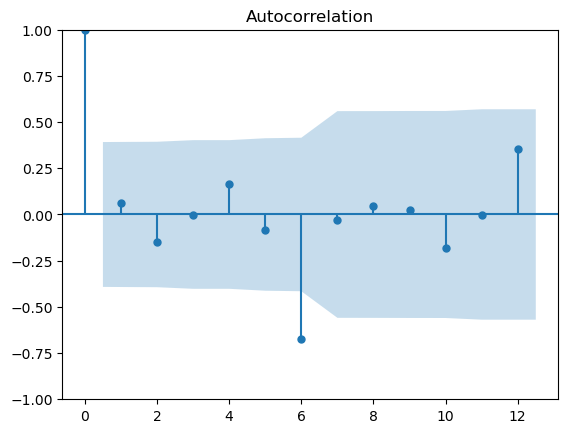

In [23]:
tsaplots.plot_acf(train_df['1991-01-01':'1993-01-01'].Ridership,lags=12)
plt.show()
                         # --> plot della funzione di autocorrelazione (acf).
                         #     i lag sono plottati in ascissa e le correlazioni in ordinata.

La serie originaria (*lag-0*) ha per definizione correlazione con se stessa 1, non ha IC, e non si considera.<br>
La correlazione più forte è per **lag-6** (negativa), che eccede anche gli IC, e poi per **lag-12** (positiva).<br>
[Autocorrelazioni che eccedono gli IC suggeriscono possibili miglioramenti del modello.]<br>
Sembra cioè esserci un **pattern semestrale**: ogni 6 mesi i viaggiatori aumentano o diminuiscono (<u>si invertono</u>, perciò auto-correlazione negativa). 

E' molto utile, dopo aver fittato la regressione con trend quadratico e stagionalità (vedi prima), visualizzare anche **il plot dell'auto-correlazione dei RESIDUI (con gli IC)**, anzichè quella dei VALORI vista prima:

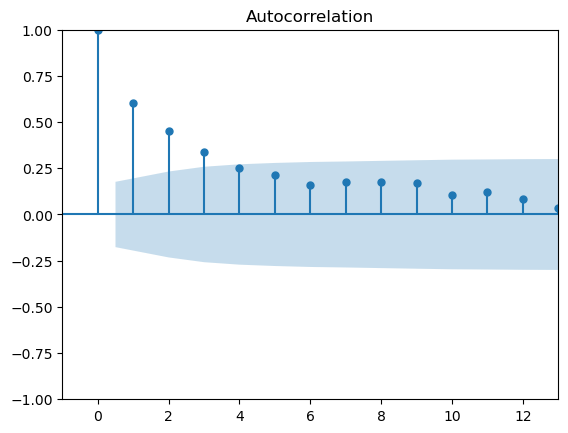

[1.         0.60405883 0.44983171 0.3373083  0.25329034 0.21565844
 0.15901326 0.17676683 0.17553762 0.17140882 0.10739472 0.11976519
 0.08512942]


In [24]:
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df) 
                                                   # NB. 'ridership_lm_trendseason', come dice il suo nome peraltro,
                                                   # è stato fittato precedentemmente modellando un trend quadratico
                                                   # ed una stagionalità.
tsaplots.plot_acf(residual)
plt.xlim(-1, 13)
plt.show()
print(stattools.acf(residual, nlags=12, fft=True))

Il lag-6 e lag-12 non dominano più: il trend quadratico e la stagionalità (del modello di regressione scelto) modellano adeguatamente la serie.

A ben vedere, comunque, come ultimo SINTOMO, in questo plot c'è una **forte** auto-correlazione positiva <u>dal lag-1 al lag-6</u> circa. Essa indica che probabilmente c'è una **relazione positiva tra residui vicini**.<br>
E' una informazione <u>importante</u>, che può essere utilizzata per **migliorare ancora** le previsioni [nella prossima sezione].

In generale, ecco alcuni **tipici comportamenti autocorrelati** che occorre sempre esplorare in una serie:
* <u>forte auto-correlazione</u> (positiva o negativa) al **lag-k (con k>1)** ed i suoi multipli (lag-2k, lag-3k, ecc); in genere indica un pattern ciclico; ad esempio, una forte auto-correlazione al lag-12 di una serie mensile indica una **stagionalità** annuale (cioè i mesi sono correlati negli anni);
* auto-correlazione positiva al **lag-1** [(*stickiness)*](https://www.investopedia.com/terms/p/price_stickiness.asp) indica che i <u>valori consecutivi</u> di una serie si muovono in genere nella stessa direzione; ad esempio, in presenza di un forte **trend lineare**, ci aspettiamo di osservare nella serie una auto-correlazione lag-1 positiva e forte;
* auto-correlazione negativa al **lag-1** indica la presenza di *oscillazioni* nella serie: valori alti sono immediatamente seguiti da valori bassi.

---
**Quanti lag?**
- con $T$ osservazioni, non ha molto senso andare oltre $\sqrt(T)$
- oppure, criterio meno frequente, ci si ferma a $T/4$
- se la serie è mensile, almeno 12 lag (la stagionalità annuale)
- se la serie è giornaliera, almeno 30 lag
- se la serie è trimestrale, almeno 4 lag (1 anno)

---

# Migliorare le previsioni integrando le informazioni sull'auto-correlazione

---

Se conosciamo le auto-correlazioni possiamo usarle per **aggiustare le previsioni e migliorarle**.

---

Ci sono <u>due modi</u> per migliorare le previsioni con le informazioni sull'auto-correlazione della serie:
* a) inserire l'autocorrelazione **direttamente nel modello di regressione**;
    * sono i modelli [auto-regressivi (AR)](https://it.wikipedia.org/wiki/Modello_autoregressivo), un caso particolare dei più generali modelli [ARIMA](https://it.wikipedia.org/wiki/Modello_autoregressivo_integrato_a_media_mobile) (Auto-Regressive Integrated Moving Average); 
    * sia i modelli ARIMA che anche i più semplici modelli AR richiedono capacità di **trasformare i dati** opportunamente, di scegliere l'ordine del modello ed, in generale, maggiori **competenze statistiche**;
    * inoltre, i modelli ARIMA sono **meno robusti**;
    * [AR**I**MA è un caso particolare di ARMA].
<br><br>
      
* b) l'approccio in genere <u>più diffuso</u> è il **modello a due livelli** [*t* rappresenta l'ultimo valore della serie oppure un modello AR(1)]:
    * 1) generare un forecast F(t+k) con un qualche metodo di TSF (ad es. la regressione con trend e stagionalità di *Amtrak*);
    * 2) fittare i RESIDUI del passo b.1 con un modello AR e generare così un forecast del residuo E(t+k); è questo cioè un modello di forecasting **di secondo livello** (sui RESIDUI del modello di primo livello, che era stato fittato sui VALORI della serie);
    * 3) aggiustare i forecast di primo livello F(t+k) con E(t+k):

Il modo b. è semplice ed efficace nel migliorare i forecast **a breve termine**.<br>

Nel passo b.2, per fittare i *residui*, dobbiamo prima esaminare **le auto-correlazioni dei residui stessi** (applicando cioè <u>la stessa logica</u> che avevamo applicato ai *valori* nelle sezioni precedenti di questo notebook.)<br>
Il modello AR del passo b.2 è in genere sufficiente che sia di ordine 1 [detto **AR(1)**]. (Ciò perchè, se i valori della serie immediatamente vicini sono correlati, allora la relazione si propaga ai valori distanti 2, e poi a quelli distanti 3, e così via.)<br>

Il metodo a due livelli è un metodo di **combinazione di modelli**. Un altro metodo di combinazione di modelli è l'**"ensemble"**, nel quale si applicano alla serie molti modelli previsionali differenti e quindi si fa la media (in vari modi) delle varie previsioni per ottenere la previsione finale.

⚠️ **In questo notebook esaminiamo il modo a).**

# Modelli AR

## Il modello teorico
I modelli AR sono **simili ai modelli di regressione**, con la differenza che i predittori sono i VALORI **passati** della serie. Per esempio, un modello auto-regressivo di ordine 2, detto **AR(2)**, ha la seguente forma (come processo generativo dei dati):
$$Y_t =\beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \epsilon$$

dove:
- $\beta_0$ (anche detta costante *c*) = l'intercetta (opzionale);
- $\beta_1$, $\beta_2$ = coefficienti autoregressivi da stimare;
- $\epsilon$ = shock casuale, aka rumore bianco, con media zero e varianza costante.

Un modello di questo tipo tiene conto della dipendenza tra osservazioni. 

Rispetto a quanto fatto finora:
- Il modello di regressione classico NON tiene conto delle correlazioni. O meglio esse sono un problema (tra i predittori).
- Naive Forecast e Seasonal Naive Forecast non costruiscono modelli (sono metodi parametrici).

**Cosa è $p=2$?**<br>
“2” indica **l’ordine del modello**, cioè **quanti lag (ritardi) vengono usati per spiegare il valore corrente *t***:
- un modello **AR(1)** usa solo il valore immediatamente precedente $Y_t$
- un modello **AR(2)** usa i due valori precedenti $Y_{t-1}$ e $Y_{t-2}$
- un modello **AR(p)** in generale usa i precedenti fino a $Y_{t-p}$

## Il comportamento della serie al variare dei coefficienti
Come cambia il comportamento della serie al variare dei coefficienti?

**1. Ruolo dei coefficienti $\beta_1$ e $\beta_2$**
- $\beta_1$ controlla quanto pesa l’ultimo valore passato $Y_{t-1}$
- $\beta_2$ controlla quanto pesa il penultimo valore passato $Y_{t-2}$
- Insieme determinano:
    - la **stazionarietà**, cioè se la serie si stabilizza o esplode
    - il **tipo di dinamica** (decadimento regolare, oscillazioni, ecc.).

**2. Condizioni di stazionarietà per AR(2)**<br>
La serie è stazionaria se le radici del polinomio caratteristico $1 - \beta_1z - \beta_2 z^2 = 0$
sono fuori dal cerchio unitario (cioè con modulo > 1). Vedi nota di chatGPT5 a fine cella.

👉 Se non rispettato, la serie diverge (instabile).

**3. Tipi di comportamento**
- $\beta_2 = 0$ --→ diventa un AR(1): dipende solo da $Y_{t_1}$, andamento semplice, decadimento esponenziale verso la media
- $\beta_2 > 0$ --→ i due lag “spingono” nella stessa direzione → possibile memoria lunga e decadimento lento.
    - Decadimento lento = le autocorrelazioni della serie diminuiscono piano piano (restano alte anche a lag grandi).
    - Memoria lunga = il passato “pesa” a lungo: anche osservazioni molto vecchie influenzano ancora in modo significativo il presente.
    - Se si guarda l’ACF, in una serie con memoria lunga non “crolla” subito a zero, ma scende lentamente.
- $\beta_2 < 0$ --→ introduce oscillazioni: il valore al tempo $t$ tende a muoversi in senso opposto rispetto a $t-2$
- $\beta_1$ grande (positivo) --→ forte persistenza, la serie segue a lungo il trend passato.
- $\beta_1$ negativo --→ alternanza di segno, oscillazioni più marcate.

**4. Esempi classici (da manuali di time series)**
- $\beta_1 = 0.6$ , $\beta_2 = -0.2$ --→ serie oscillante ma stazionaria.
- $\beta_1 = 1.5$ , $\beta_2 = -0.7$ --→ oscillazioni con memoria lunga, tipo “onde smorzate”.
- $\beta_1 = 0.9$ , $\beta_2 = 0.05$ --→ andamento simile ad AR(1), decadimento lento ma senza oscillazioni.

**📊 In pratica:**
- Segno di $\beta_2$ --→ determina oscillazioni sì/no.
- Valore assoluto di $\beta_1$ e $\beta_2$ --→ determina persistenza o esplosione.

**TERMINI**:
- **Persistenza** 👉 il processo ricorda molto il passato: gli shock $\epsilon_t$ si propagano a lungo ma la serie resta stabile e oscilla attorno a una media finita.
- **Esplosione** 👉 i coefficienti sono troppo grandi e la serie diventa instabile: i valori crescono senza controllo (varianza infinita, la media non esiste).

📌 Quindi: persistenza = memoria lunga ma stazionaria; esplosione = instabilità, la serie “scappa via”.


**Nota di chatGPT5 sul polinomio caratteristico e le sue radici**<br>
![](Radici_polinomio_caratteristico.png)

Vediamo un **grafico comparativo simulato in Python** con i **3 esempi classici di ($\beta_1$ , $\beta_2$) visti prima**, così si vede la differenza visivamente:

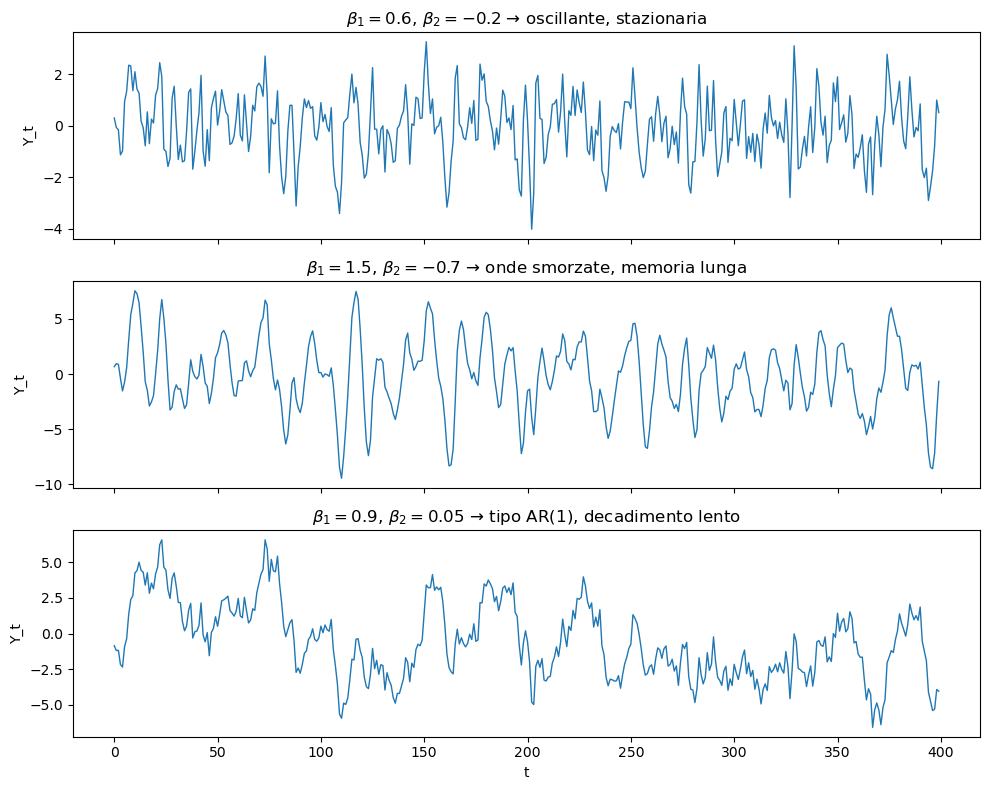

In [25]:
# Grafico con 3 subplot condividendo lo stesso asse x (tempo)
import numpy as np
import matplotlib.pyplot as plt

def sim_ar2(phi1, phi2, n=400, burn=300, sigma=1.0, seed=123):
    rng = np.random.default_rng(seed)
    e = rng.normal(0, sigma, size=n+burn+2)
    y = np.zeros(n+burn+2)
    for t in range(2, len(y)):
        y[t] = phi1*y[t-1] + phi2*y[t-2] + e[t]
    return y[burn+2:]

scenarios = [
    (0.6, -0.2, r"$\beta_1=0.6$, $\beta_2=-0.2$ → oscillante, stazionaria"),
    (1.5, -0.7, r"$\beta_1=1.5$, $\beta_2=-0.7$ → onde smorzate, memoria lunga"),
    (0.9,  0.05, r"$\beta_1=0.9$, $\beta_2=0.05$ → tipo AR(1), decadimento lento")
]

fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)

for ax, (phi1, phi2, label) in zip(axes, scenarios):
    y = sim_ar2(phi1, phi2, n=400, burn=300, sigma=1.0, seed=42)
    ax.plot(y, linewidth=1.0)
    ax.set_ylabel("Y_t")
    ax.set_title(label)

axes[-1].set_xlabel("t")
plt.tight_layout()
plt.show()


Esaminiamo meglio i 3 scenari plottati:

**🔹 1. β₁=0.6, β₂=−0.2 → oscillante ma stazionaria**:
- il termine β₂ negativo introduce una tendenza all’alternanza: se il valore due periodi fa era alto, oggi tende a essere più basso, e viceversa.
- L’ampiezza delle oscillazioni però decresce nel tempo, perché i coefficienti non sono troppo grandi → la serie resta stabile e gira attorno a una media costante.
- Attenzione: la diminuzione progressiva non è facile da vedere a causa del rumore casuale
- ACF: decresce con cambi di segno → tipico di oscillazioni smorzate.

📌 Immagine intuitiva: **un pendolo che oscilla, ma ogni volta un po’ meno**.

**🔹 2. β₁=1.5, β₂=−0.7 → onde smorzate, memoria lunga**:
- Entrambi i coefficienti sono grandi (ma in combinazione ancora stazionari).
- Questo genera oscillazioni più lunghe e persistenti rispetto al caso 1.
- Lo shock casuale rimane “vivo” per molto tempo: la serie ha lunga memoria, prima di tornare alla media.
- Visivamente si notano onde ampie che impiegano parecchi step a spegnersi.

📌 Immagine intuitiva: **una molla molto elastica che continua a vibrare a lungo prima di fermarsi**.

**🔹 3. β₁=0.9, β₂=0.05 → tipo AR(1), decadimento lento senza oscillazioni**:
- Qui β₂ è piccolo e positivo → il contributo del secondo lag è quasi nullo.
- La dinamica è dominata dal primo lag (β₁=0.9), molto vicino a 1.
- Questo crea alta persistenza: i valori restano simili a lungo, e gli shock impiegano molto tempo a spegnersi.
- Non ci sono vere oscillazioni, ma un lento ritorno alla media.

📌 Immagine intuitiva: **una biglia in una ciotola larga che rotola lentamente verso il centro, senza rimbalzare.**

## L'intercetta $\beta_0$

**Quando la costante è necessaria?**
- Se la serie ha una media non nulla (cioè oscilla attorno a un valore ≠ 0), allora serve l’intercetta $c$. In tal caso, $c$ “sposta” la traiettoria intorno alla media vera della serie.
- Senza intercetta, il modello forzerebbe la media a 0, introducendo bias.

**Quando la costante è opzionale / evitabile:**
- Se la serie è centrata (cioè si è sottratta la media prima di stimare il modello → $E[Y_t] = 0$, allora la costante non serve.
- Alcune librerie (es. `statsmodels.AutoReg`) hanno il parametro `trend` che può essere:
- `c` → include la costante,
- `nc` → no constante
- `ct` → costante + trend lineare
- `ctt` → costante + trend lineare + quadratico.

**In pratica:**
- Serie stazionarie centrate (tipo simulazioni teoriche o dopo differenziazione) → spesso si mette `trend="nc"`.
- Serie reali (es. consumi energetici, PIL, temperature) → di solito si include sempre la costante (`trend="c"`), a meno che non si sia già tolta la media.

👉 **Quindi la costante $\beta_0$ è “opzionale” a seconda pre-processing fatto oppure no:**
- Se i dati hanno media ≠ 0 → mettere la costante
- Se si è già centrato/differenziato → si può togliere.
  
Vediamo un **esempio pratico con e senza costante**, così si vede come cambia la media stimata della serie.

In [26]:
# A) Scegliere p (AIC/BIC) – versione console, senza grafici

# pip install numpy statsmodels
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# 1) Simula un vero AR(2): Y_t = 0.6 Y_{t-1} - 0.2 Y_{t-2} + e_t
rng = np.random.default_rng(321)
n, burn = 600, 400
phi1, phi2, sigma = 0.6, -0.2, 1.0
e = rng.normal(0, sigma, size=n+burn+2)
y = np.zeros(n+burn+2)
for t in range(2, len(y)):
    y[t] = phi1*y[t-1] + phi2*y[t-2] + e[t]
y = y[burn+2:]

# 2) Valuta AR(p) per p=1..10 e stampa AIC/BIC
print("p   AIC        BIC")
best_bic = (None, float("inf"))
for p in range(1, 11):
    res = AutoReg(y, lags=p, trend="c", old_names=False).fit()
    print(f"{p:<2}  {res.aic:10.3f}  {res.bic:10.3f}")
    if res.bic < best_bic[1]:
        best_bic = (p, res.bic)

print(f"\n=> p scelto da BIC: {best_bic[0]}")

p   AIC        BIC
1     1721.064    1734.249
2     1666.440    1684.014
3     1666.125    1688.084
4     1665.535    1691.876
5     1664.807    1695.527
6     1664.517    1699.612
7     1664.212    1703.679
8     1662.392    1706.227
9     1662.550    1710.750
10    1661.171    1713.733

=> p scelto da BIC: 2


In [27]:
# B) Intercetta “sì/no” – effetto sulla media (solo stampe)
# pip install numpy statsmodels
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# Simula AR(1) con intercetta: Y_t = 5 + 0.7 Y_{t-1} + e_t
rng = np.random.default_rng(999)
n, burn, c, phi, sigma = 300, 150, 5.0, 0.7, 1.0
e = rng.normal(0, sigma, size=n+burn+1)
y = np.zeros(n+burn+1)
for t in range(1, len(y)):
    y[t] = c + phi*y[t-1] + e[t]
y = y[burn+1:]

# Fit con costante
m_c = AutoReg(y, lags=1, trend="c", old_names=False).fit()
phi_hat, c_hat = m_c.params[1], m_c.params[0]
mean_hat = c_hat / (1 - phi_hat)

# Fit senza costante
m_n = AutoReg(y, lags=1, trend="n", old_names=False).fit()

print(f"Media empirica         = {y.mean():.3f}")
print(f"Con costante:  phi={phi_hat:.3f}, c={c_hat:.3f}, media stimata={mean_hat:.3f}")
print(f"Senza costante: phi={m_n.params[0]:.3f} (media forzata a 0)")


Media empirica         = 16.477
Con costante:  phi=0.673, c=5.396, media stimata=16.481
Senza costante: phi=0.998 (media forzata a 0)


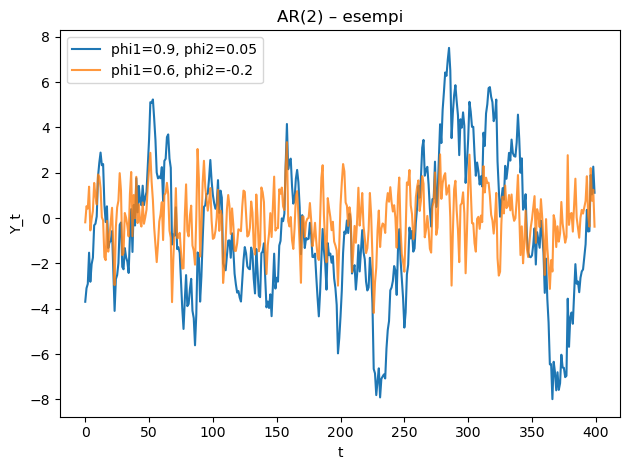

In [28]:
# C - Mini-grafico per vedere le traiettorie

# pip install numpy matplotlib
import numpy as np, matplotlib.pyplot as plt

def sim_ar2(phi1, phi2, n=400, burn=300, sigma=1.0, seed=123):
    rng = np.random.default_rng(seed)
    e = rng.normal(0, sigma, size=n+burn+2)
    y = np.zeros(n+burn+2)
    for t in range(2, len(y)):
        y[t] = phi1*y[t-1] + phi2*y[t-2] + e[t]
    return y[burn+2:]

y1 = sim_ar2(0.9, 0.05)      # tipo AR(1), decadimento lento
y2 = sim_ar2(0.6, -0.2)      # oscillazioni smorzate

plt.plot(y1, label="phi1=0.9, phi2=0.05")
plt.plot(y2, label="phi1=0.6, phi2=-0.2", alpha=0.8)
plt.legend(); plt.xlabel("t"); plt.ylabel("Y_t"); plt.title("AR(2) – esempi"); plt.tight_layout(); plt.show()


## Modelli di `statsmodels.tsa`
Prima di fare il fit su *Amtrak* di un modello AR, vediamo **una sintesi dei modelli di *time series* resi disponibili dalla libreria `statsmodels.tsa`**:

![](Modelli_statsmodels.tsa.png)

**L'albero corrispondente**:<br>
![](Modelli_statsmodels.tsa_chatGPT5.png)

**E i modelli di [smoothing](https://medium.com/@srv96/smoothing-techniques-for-time-series-data-91cccfd008a2)?**<br>
![](smoothing_in_statsmodelstsa.png)

## Esempio con Amtrak

Vediamo come si **implementa un modello AR(2) con `statsmodesl.tsa`** sul dataset *Amtrak*.<br>
Si **impara su piccoli dataset**, poi si utilizzano quelli grandi!

In [29]:
# import
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates

# caricamento dati
df = pd.read_csv('Amtrak.csv')
ridership_col = 'Ridership'

# seed per eventuali parti random del codice (qui non ce ne sono, in questo caso)
import numpy as np
np.random.seed(42)

# fit AR(2)
y = df[ridership_col].astype(float)
ar2 = AutoReg(y, lags=2, old_names=False).fit()   # stima con conditional MLE
                                                  # dal punto di vista python, questa riga invoca 2 metodi in cascata:
                                                  # - il metodo 'AutoReg' crea l'oggetto 'ar2' appartenente alla classe dei modelli AR(2)
                                                  # - il metodo fit è applicato in cascata
ar2.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  159
Model:                     AutoReg(2)   Log Likelihood               -1008.801
Method:               Conditional MLE   S.D. of innovations            149.388
Date:                Mon, 15 Sep 2025   AIC                           2025.602
Time:                        23:17:30   BIC                           2037.827
Sample:                             2   HQIC                          2030.567
                                  159                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          745.6636    136.315      5.470      0.000     478.491    1012.836
Ridership.L1     0.5344      0.080      6.639      0.000       0.377       0.692
Ridership.L2     0.0580      0.080      0.721      0.471      -0.100       0.216
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5953           +0.0000j            1.5953            0.0000
AR.2          -10.8136           +0.0000j           10.8136            0.5000
-----------------------------------------------------------------------------
"""

Se i **numeri o il layout differiscono**, dipende da:
- versione di `statsmodels`
    - il modo più sicuro per controllarla è: `!conda list statsmodels` (sul MIO PC a settembre-25 c'è la **0.14.4**)
- tipo di float (`float32` vs `float64`)
- [libreria BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) installata (è una libreria di algebra lineare)
- inizializzazione del random generator (vedi più avanti)

In [30]:
!conda list statsmodels

# packages in environment at C:\Users\Utente\anaconda3:
#
# Name                     Version          Build            Channel
statsmodels                0.14.4           py313h827c3e9_0


---
**📌 Nota sulle metriche di bontà / selezione dei modelli statistici (di chatGPT5)**<br>
![](metriche_selezione_modelli.png)

**📌 Nota sulle metriche di bontà / selezione dei modelli statistici (di **Hastie & Tibshirani**)**<br>

In [31]:
from IPython.display import IFrame
IFrame("Metriche_selezione_modelli_H&T.pdf", width=1000, height=1000)

**Interpretazione di chatGPT5 del modello AR(2) su *Amtrak*** - il codice NON ha parti casuali dunque l'output è sempre questo finché si usa la stessa versione di `statsmodels`.<br>
![](interpretazione_chatGPT5_modello_AR2_Amtrak.png)

Si può ottenere lo stesso output in **formato testuale** in questo modo:

In [32]:
ar2 = AutoReg(y, lags=2, old_names=False).fit()
ar2_summary = ar2.summary()
print(ar2_summary.as_text())

                            AutoReg Model Results                             
Dep. Variable:              Ridership   No. Observations:                  159
Model:                     AutoReg(2)   Log Likelihood               -1008.801
Method:               Conditional MLE   S.D. of innovations            149.388
Date:                Mon, 15 Sep 2025   AIC                           2025.602
Time:                        23:17:34   BIC                           2037.827
Sample:                             2   HQIC                          2030.567
                                  159                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          745.6636    136.315      5.470      0.000     478.491    1012.836
Ridership.L1     0.5344      0.080      6.639      0.000       0.377       0.692
Ridership.L2     0.0580      0.080      0.72

Seguiamo il consiglio di chatGPT5 e **fittiamo un modello AR(1)**:

In [33]:
# fit AR(1)
ar1 = AutoReg(y, lags=1).fit()   # stima con conditional MLE
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  159
Model:                     AutoReg(1)   Log Likelihood               -1015.422
Method:               Conditional MLE   S.D. of innovations            149.573
Date:                Mon, 15 Sep 2025   AIC                           2036.844
Time:                        23:17:34   BIC                           2046.032
Sample:                             1   HQIC                          2040.575
                                  159                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          784.4868    120.958      6.486      0.000     547.414    1021.560
Ridership.L1     0.5705      0.066      8.627      0.000       0.441       0.700
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7529           +0.0000j            1.7529            0.0000
-----------------------------------------------------------------------------
"""

**Interpretazione di chatGPT5 del modello AR(1) su *Amtrak***<br>
![](interpretazione_chatGPT5_modello_AR1_Amtrak.png)

---

Noi conosciamo bene la struttura di Ridership di Amtrak, l'abbiamo studiata molte volte con strumenti differenti. Essa include **trend (quadratico)** e **stagionalità annuale**. Dunque **non + stazionaria**!!

`AutoReg` (statsmodels) stima un modello AR puro con MLE condizionale.
- Ma è progettato per serie stazionarie.
- Se applichiamo `AutoReg` direttamente alla serie *Amtrak*, otteniamo:
    - Parametri stimati (statisticamente calcolabili).
    - Residui però autocorrelati e non rumore bianco.
    - **Quindi il modello sarà mal specificato** (AIC e BIC <u>probabilmente</u> alti).

---

Nell'ACF di Amtrak ci sono picchi netti a lag 6 e lag 12, come visto prima. Significa che c’è una stagionalità annuale (12) e un’oscillazione semestrale (armonica a 6). Si può provare con SARIMA (ARIMA stagionale) o SARIMAX (una generalizzazione di SARIMA: oltre alla parte ARIMA stagionale, permette di aggiungere variabili esplicative (exog).)

---

## Confronto con il modello di regressione OLS
Un modello AR(2): $$Y_t =\beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \epsilon$$ fittato con la funzione `AutoReg` di `statsmodels.tsa.ar_model` è (abbastanza) <u>equivalente</u> ad un modello di regressione lineare OLS con
- la risposta Y = il valore della serie (per Amtrak: *Y = Ridership*)
- i predittori: le due serie lagged (1 e 2 in questo esempio)

cioé:

$$Y_{lag0} = \beta_0 + \beta_1Y_{lag1} + \beta_2Y_{lag2} +\epsilon$$

Perchè? Perchè **la funzione `AutoReg` di `statsmodels.tsa.ar_model` utilizza il metodo MLE condizionale che coincide con OLS**. Minimizzare i residui (come fa OLS) è uguale a massimizzare la log-likelihood condizionata.

E' anche per questo che, quando si analizzano *time series*, è importante conoscere anche la Regressione Lineare OLS!<br>

📌 **Differenze concettuali**:
- <u>Regressione classica OLS</u>:
    - ipotesi che gli errori ϵ siano i.i.d., senza correlazione seriale.
    - I regressori $Y_{t-1}$ e $Y_{t-2}$ sarebbero trattati come variabil “esterne” osservate.
- <u>Autoregressione (AR)</u>:
    - si riconosce che i regressori sono in realtà la stessa variabile laggata → la dipendenza temporale è la caratteristica principale.
    - la struttura degli errori $\epsilon_t$ è cruciale: devono essere rumore bianco (non correlato, varianza costante).

📊 **In pratica**:

Se si prendono i dati $(Y_1, Y_2, ..., Y_T)$ e si  costruisce un dataset così:<br>
![](dataset_tipo_regressione.png)

allora un **OLS classico** di $Y_t$ su $Y_{t-1}$ e $Y_{t-2}$ **stima gli stessi coefficienti $\beta_0$ , $\beta_1$ e $\beta_2$ dell’AR(2) condizionale** (cioè stimato con MLE condizionale).

🔑 La differenza sostanziale è che in un modello di regressione non ci si preoccupa (almeno in prima battuta) di autocorrelazione nei residui:
- si guarda la relazione tra variabili esplicative X e la risposta y
- L’obiettivo è stimare i coefficienti $\beta_i$
- Non si parte preoccupandosi che i residui siano autocorrelati nel tempo → l’assunzione standard è che siano indipendenti, ma spesso questo si scopre dopo e al limite si corregge (es. con Newey-West, GLS, ecc.).<br>

Al contrario, nella AR:
- La variabile dipendente è spiegata solo dai suoi lag passati.
- Qui l’ipotesi fondamentale è che gli errori $\epsilon_t$ siano rumore bianco: media zero, varianza costante, non autocorrelati.
- Perché? Perché tutta la dipendenza temporale deve essere spiegata dai lag di Y.
- Se resta autocorrelazione nei residui, significa che i lag non bastano → modello sbagliato o incompleto.

🔹 In sintesi
- In regressione classica → si guarda prima al legame tra Y e X, poi si controllano i residui.
- In AR(p) → l’obiettivo stesso è “ripulire” la serie dalla dipendenza temporale, quindi i residui devono già essere rumore bianco.

📌 **Se i residui di un AR hanno ancora autocorrelazione → il modello non è adeguato** (serve aumentare p, o passare a ARMA/ARIMA).


## Le due matrici di disegno X

La **matrice di disegno** (*design matrix X*) del modello OLS: $$Y_{lag0} = \beta_0 + \beta_1Y_{lag1} + \beta_2Y_{lag2} +\epsilon$$ visto prima è **differente** da quella del modello OLS: $$Y_t = \beta_01 + \beta_1t + \beta_2t^2 + \epsilon$$ visto nel notebook *B. Gestione delle serie temporali*!

In OLS infatti si può costruire 𝑋 in due modi molto diversi:
- $X = [1,t,t2,season]$ (trend/season deterministici)
- $X = [1,y_{t−1}, y_{t−2}, …]$ (lag di 𝑦 → AR(p))

**Differenze**:
- Prima matrice (trend + stagionalità deterministica) → non modella l’autocorrelazione.
    - Spiega solo parti “deterministiche” (trend e cicli fissi).
    - Se la serie ha residui autocorrelati, il modello non lo gestisce → i residui non saranno rumore bianco.
- Seconda matrice (lag autoregressivi) → modella l’autocorrelazione.
    - Usa i valori passati della serie per spiegare la dipendenza temporale.
    - Se la specificazione è giusta, i residui risultano bianchi (non autocorrelati).

👉 quindi: la differenza cruciale è che i **lag catturano la dinamica interna (autocorrelazione), mentre i termini deterministici catturano solo pattern “esterni” (trend e stagionalità fissi)**.

**Qaundo usarle**:
- Trend/season: reportistica, lungo periodo, pattern stabili, interpretabilità.
- Lag/AR: previsione a breve, forte inerzia, focus su dinamica.

---

Vediamo il codice di confronto:
- `AutoReg`
- `sm.OLS` + `lagmat` (che costruisce la matrice dei lag

In [34]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.tsatools import lagmat

# 1) Carico la serie
df = pd.read_csv("Amtrak.csv")
y = df["Ridership"].astype(float)

# ---------- Metodo 1: AutoReg ----------
ar2 = AutoReg(y, lags=2, old_names=False).fit()
print("=== AutoReg AR(2) ===")
print(ar2.params)

# ---------- Metodo 2: OLS manuale ----------
# creo la matrice dei lag (maxlag=2), tolgo prime due osservazioni
lags = lagmat(y, maxlag=2, trim="both")
y_reg = y[2:]   # allineamento

X = sm.add_constant(lags)   # aggiungo intercetta
ols_model = sm.OLS(y_reg, X).fit()
print("\n=== OLS manuale ===")
print(ols_model.params)

# ---------- Confronto residui ----------
print("\nResidui identici? ", np.allclose(ar2.resid, ols_model.resid))

=== AutoReg AR(2) ===
const           745.663582
Ridership.L1      0.534356
Ridership.L2      0.057967
dtype: float64

=== OLS manuale ===
const    745.663582
x1         0.534356
x2         0.057967
dtype: float64

Residui identici?  True


Vediamo la matrice *numpy* dei lag `lagmat` affianacata a `y`:

In [35]:
lags = lagmat(y, maxlag=2, trim="both")
y_aligned = y[2:].reset_index(drop=True)

lags_df = pd.DataFrame(lags, columns=["lag1", "lag2"])
lags_df.insert(0, "y", y_aligned)
print(lags_df.head(10))

          y      lag1      lag2
0  1972.715  1620.586  1708.917
1  1811.665  1972.715  1620.586
2  1974.964  1811.665  1972.715
3  1862.356  1974.964  1811.665
4  1939.860  1862.356  1974.964
5  2013.264  1939.860  1862.356
6  1595.657  2013.264  1939.860
7  1724.924  1595.657  2013.264
8  1675.667  1724.924  1595.657
9  1813.863  1675.667  1724.924


---
I parametri stimati (intercetta, coeff. lag1, coeff. lag2) sono gli stessi con AutoReg e con OLS.<br>
I residui (.resid) coincidono esattamente → stesso modello.

`AutoReg(y, lags=2)` non fa altro che **costruire i lag** e stimare una regressione OLS. È identico a farlo “a mano” con `sm.OLS`.

Ecco i risultati a confronto (attenzione, i modelli a sx sono quelli del notebook *B. Gestione delle serie temporali* dove si è usata la matrice di disegno [1,t,t2, ecc] e NON quella dei lag!):<br>
![](OLS_vs_MSE.png)<br>

La regressione con trend e stagionalità ha fatto molto meglio di AR(2) (AIC ed BIC molto più bassi).<br>
Ma forse $p=2$ non è ottimale??


## L'ordine *p*

Qual è il valore **ottimale** di *p*?
La scelta dell’ordine *p* (cioè quanti lag inserire in un modello AR(p)) non ha un valore “migliore universale”, ma dipende da diversi fattori, quali:<br>

**1. Teoria vs pratica**
- In teoria: se conoscessimo il vero processo generativo, sceglieremmo quel valore di *p* 
- In pratica: il valore tipico di *p* si sceglie stimandolo dai dati, bilanciando accuratezza e semplicità.

**2. Criteri più usati**
- **AIC** (Akaike Information Criterion)
- **BIC** (Bayesian Information Criterion / Schwarz criterion)
- **HQIC** (Hannan–Quinn)

👉 Si fittano vari modelli AR(p) con p=1,2,…, e si sceglie quello con criterio minimo.<br>
In genere:
- AIC tende a favorire modelli più complessi (p alto).
- BIC è più “parsimonioso”, quindi spesso preferito.

**3. Indicazioni pratiche**
- Molte serie economiche e finanziarie → bastano AR(1) o AR(2).
- Serie con ciclicità/oscillazioni → AR(2) spesso cattura già bene.
- Se la serie è più complessa → si va verso AR(3), AR(4), … ma raramente oltre 5–6 in applicazioni standard.

**4. Regola empirica (di *Box–Jenkins*)**
- Si guarda l’ACF (Autocorrelation Function) e la PACF (Partial ACF):
    - PACF che si “taglia” bruscamente dopo lag *p* → candidato AR(p).
    - ACF che decresce gradualmente → tipico comportamento AR.
- Confronto di AIC/BIC su modelli diversi.

📌 In sintesi:
- Non c’è un “migliore p” universale.
- Tipico in molti casi = 1 o 2.
- La scelta reale → con PACF + AIC/BIC.

**Selezione del miglior ordine p per il modello AR(p) sulla serie *Amtrak***:

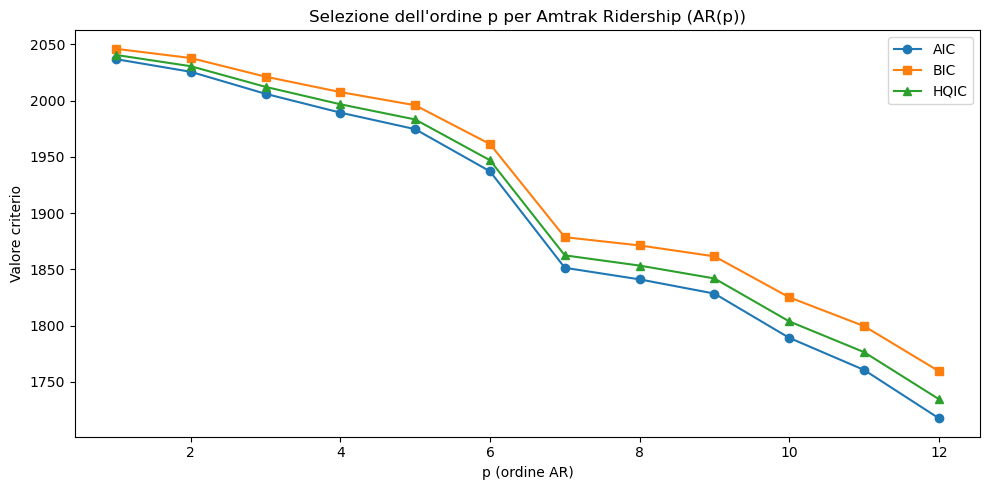

,AIC,BIC,HQIC
p,,,
1,2036.84,2046.03,2040.58
2,2025.60,2037.83,2030.57
3,2006.01,2021.26,2012.21
4,1989.30,2007.56,1996.71
5,1974.59,1995.85,1983.22
6,1937.11,1961.35,1946.96
7,1851.35,1878.57,1862.41
8,1841.06,1871.23,1853.31
9,1828.41,1861.53,1841.87


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Carico i dati
df = pd.read_csv("Amtrak.csv")
y = df["Ridership"].astype(float).to_numpy()
n = len(y)

# Testiamo p da 1 a 12 (un anno di lag, plausibile per dati mensili)
rows = []
for p in range(1, 13):
    try:
        res = AutoReg(y, lags=p, old_names=False).fit()
        rows.append({"p": p, "AIC": res.aic, "BIC": res.bic, "HQIC": res.hqic})
    except Exception as e:
        rows.append({"p": p, "AIC": np.nan, "BIC": np.nan, "HQIC": np.nan})

crit_df = pd.DataFrame(rows).set_index("p")

# Plot criteri informativi
plt.figure(figsize=(10,5))
plt.plot(crit_df.index, crit_df["AIC"], marker='o', label="AIC")
plt.plot(crit_df.index, crit_df["BIC"], marker='s', label="BIC")
plt.plot(crit_df.index, crit_df["HQIC"], marker='^', label="HQIC")
plt.xlabel("p (ordine AR)")
plt.ylabel("Valore criterio")
plt.title("Selezione dell'ordine p per Amtrak Ridership (AR(p))")
plt.legend()
plt.tight_layout()
plt.show()

crit_df.round(2)


Abbiamo testato modelli AR(p) con $p = 1$ fino a $p = 12$ sulla serie `Amtrak Ridership`.

**📊 Risultati (criteri informativi)**:
- AIC: minimo a p=12 (1717.6).
- BIC: minimo a p=7 (1878.6).
- HQIC: minimo a p=12 (1734.6).

**🔹 Interpretazione**:
- AIC e HQIC favoriscono modelli più complessi → suggeriscono AR(12).
- BIC è più parsimonioso → preferisce AR(7).
- Questo ha senso: la serie Amtrak è mensile → un lag a 12 cattura la stagionalità annuale (effetto naturale).

**📌 Conclusione pratica**:
- Se si vuole un modello più compatto → AR(7).
- Se si vuole catturare meglio la stagionalità → AR(12).
  

Come verifichiamo **l'auto-correlazione** rimasta dopo il fit con AR(7) oppure con AR(12)?<br>
Con il plot ACF (come fatto prima sulla serie intera originale, non modellata) oppure con il grafico dei residui di un modello.

Vediamo il **grafico dei residui di AR(7) vs AR(12)** per capire quale si comporta meglio in termini di **autocorrelazione rimasta**. La cella seguente include:
- fit dei due modelli,
- grafici residui e ACF dei residui,
- stampa di AIC/BIC.

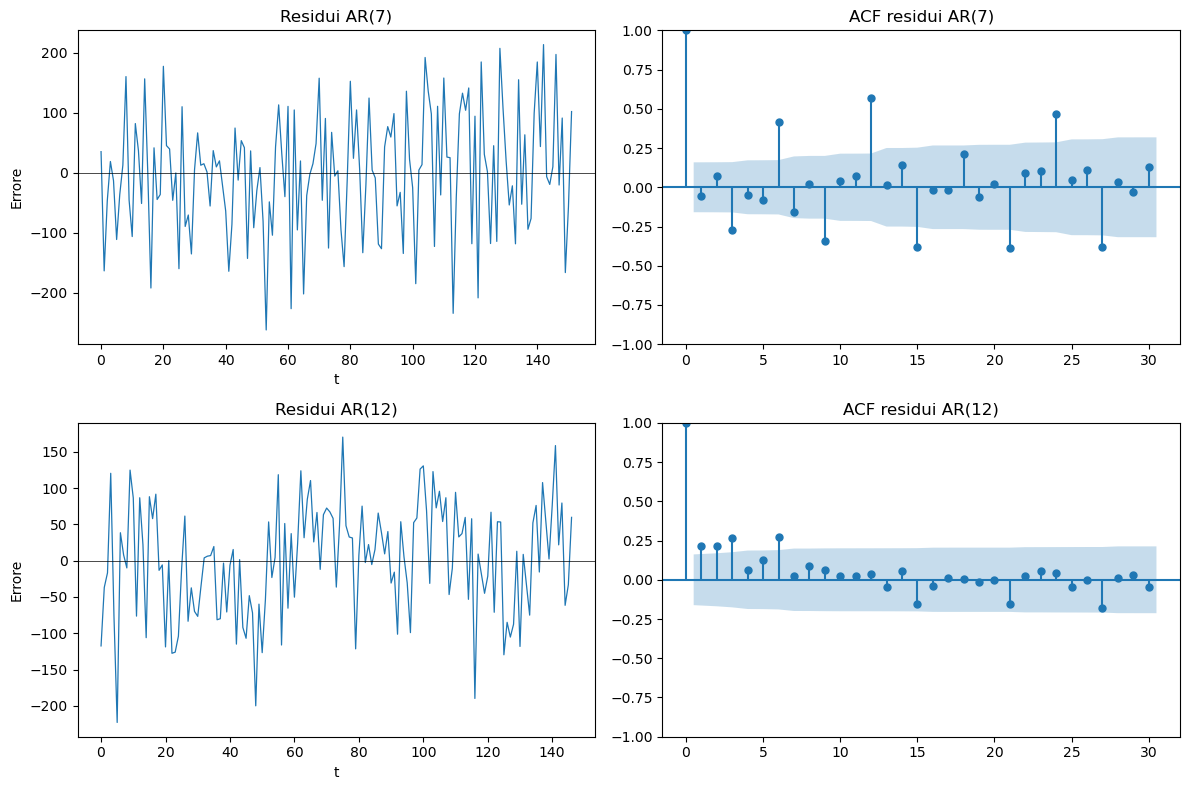

=== Confronto criteri informativi ===
AR(7) : AIC=1851.35,  BIC=1878.57
AR(12): AIC=1717.59, BIC=1759.46


In [37]:
# ============================================
# Confronto AR(7) vs AR(12) su Amtrak Ridership
# - Fit modelli
# - Grafici residui + ACF residui
# - Stampa AIC/BIC
# Requisiti: numpy, pandas, matplotlib, statsmodels
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf

# 1) Caricamento dati
path = "Amtrak.csv"  # <-- se serve, metti il percorso giusto
df = pd.read_csv(path)

# Colonna della serie (adatta se hai un nome diverso)
ridership_col = "Ridership"
y = df[ridership_col].astype(float).to_numpy()

# 2) Fit AR(7) e AR(12)
ar7  = AutoReg(y, lags=7,  old_names=False).fit()
ar12 = AutoReg(y, lags=12, old_names=False).fit()

# 3) Residui
resid7  = ar7.resid
resid12 = ar12.resid

# 4) Grafici: residui e ACF dei residui
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residui AR(7)
axes[0, 0].plot(resid7, linewidth=0.9)
axes[0, 0].axhline(0, color="black", linewidth=0.5)
axes[0, 0].set_title("Residui AR(7)")
axes[0, 0].set_xlabel("t"); axes[0, 0].set_ylabel("Errore")

# ACF residui AR(7)
plot_acf(resid7, lags=30, ax=axes[0, 1])
axes[0, 1].set_title("ACF residui AR(7)")

# Residui AR(12)
axes[1, 0].plot(resid12, linewidth=0.9)
axes[1, 0].axhline(0, color="black", linewidth=0.5)
axes[1, 0].set_title("Residui AR(12)")
axes[1, 0].set_xlabel("t"); axes[1, 0].set_ylabel("Errore")

# ACF residui AR(12)
plot_acf(resid12, lags=30, ax=axes[1, 1])
axes[1, 1].set_title("ACF residui AR(12)")

plt.tight_layout()
plt.show()

# 5) Confronto criteri informativi
print("=== Confronto criteri informativi ===")
print(f"AR(7) : AIC={ar7.aic:.2f},  BIC={ar7.bic:.2f}")
print(f"AR(12): AIC={ar12.aic:.2f}, BIC={ar12.bic:.2f}")


**Interpretazione dei plot**<br>

**🔹 Parte alta: AR(7)**:
1. Residui AR(7) (grafico a sinistra)
    - Oscillano attorno allo zero (bene), ma con varianza piuttosto ampia.
    - Alcuni pattern visibili → significa che il modello non cattura tutta la struttura della serie.
2. ACF dei residui AR(7) (grafico a destra)
    - Diverse barre (lag 12, ecc.) escono dalle bande di confidenza.
    - Indica che **i residui non sono rumore bianco** → resta autocorrelazione non spiegata → il modello non è del tutto adeguato.

**🔹 Parte bassa: AR(12)**:<br>
3. Residui AR(12) (grafico a sinistra)<br>
    - Distribuzione più “stretta” attorno a zero, meno varianza residua.<br>
    - A occhio, più simili a rumore bianco.<br>
4. ACF dei residui AR(12) (grafico a destra)<br>
    - Barre quasi tutte dentro le bande di confidenza.<br>
    - L’autocorrelazione residua è molto ridotta → il modello spiega meglio la dinamica della serie.

**📌 Conclusione**
- AR(7) lascia ancora “struttura” nei residui → non spiega bene la stagionalità.
- AR(12) cattura l’effetto stagionale annuale → residui vicini a rumore bianco.
- Coerente con i criteri informativi:
    - AIC minimo per AR(12),
    - BIC più parsimonioso suggerisce AR(7), ma con residui peggiori.

👉 Se lo scopo è la previsione accurata, meglio AR(12).<br>
👉 Se lo scopo è avere un modello più semplice e leggibile, ci si può fermare a AR(7).

---

📌 **AR(12) batte OLS con trend e stagionalità (che aveva AIC=1827, BIC=1870).**

---

E' possibile **semplificare** il modello mettendo dentro **solo il lag7 e il lag12**:

In [38]:
ar_7_12 = AutoReg(y, lags=[7,12], old_names=False).fit()
ar_7_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:             Restr. AutoReg(12)   Log Likelihood                -877.495
Method:               Conditional MLE   S.D. of innovations             94.672
Date:                Mon, 15 Sep 2025   AIC                           1762.991
Time:                        23:17:36   BIC                           1774.953
Sample:                            12   HQIC                          1767.851
                                  159                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8834    105.272      0.322      0.748    -172.445     240.212
y.L7           0.0857      0.044      1.936      0.053      -0.001       0.172
y.L12          0.9066      0.047     19.409      0.000       0.815       0.998
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0159           -0.0000j            1.0159           -0.5000
AR.2            -0.8693           -0.4976j            1.0016           -0.4173
AR.3            -0.8693           +0.4976j            1.0016            0.4173
AR.4            -0.5002           -0.8797j            1.0120           -0.3323
AR.5            -0.5002           +0.8797j            1.0120            0.3323
AR.6            -0.0076           -1.0081j            1.0081           -0.2512
AR.7            -0.0076           +1.0081j            1.0081            0.2512
AR.8             0.5078           -0.8665j            1.0044           -0.1656
AR.9             0.5078           +0.8665j            1.0044            0.1656
AR.10            1.0007           -0.0000j            1.0007           -0.0000
AR.11            0.8769           -0.5108j            1.0149           -0.0839
AR.12            0.8769           +0.5108j            1.0149            0.0839
------------------------------------------------------------------------------
"""

> **Bottom-line**: il nuovo modello semplificato con 2 soli lag (7 e 12) **semplifica molto il fit** al prezzo di un leggero aumento del AIC/BIC. E' un **trade-off più che accettabile**.

✅ Regola empirica:
- Partire dall’analisi ACF/PACF → ipotizzare un modello (pochi lag).
- Fittare il modello → guardare i residui (devono essere rumore bianco).
- Se nei residui c’è ancora autocorrelazione → aggiustare i lag.

## Previsioni *out-of-sample* (cioè fatte su un altro dataset da quello utilizzato per il training)

La cella seguente contiene il codice completo per il **confronto *out-of-sample* di AR(7) vs AR(12) su *Amtrak***, con:
- split train/test (20% per il test),
- fit dei 2 modelli con `AutoReg` (sul train set),
- previsioni sul test (*out-of-sample*),
- residui *out-of-sample* (serie e istogramma),
- **RMSE** stampato.

=== RMSE out-of-sample ===
AR(7) : 209.12
AR(12): 120.48


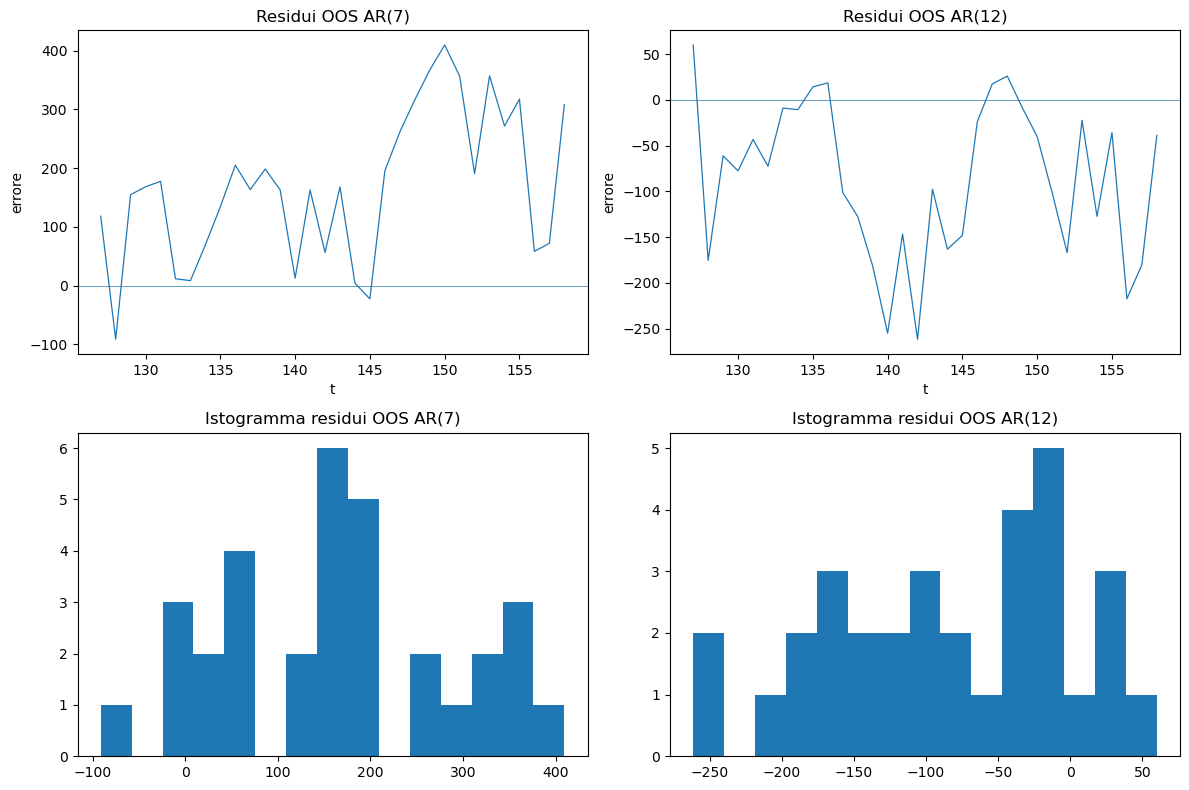

In [39]:
# ============================================
# Amtrak: confronto out-of-sample AR(7) vs AR(12)
# Residui out-of-sample + RMSE
# Requisiti: numpy, pandas, matplotlib, statsmodels, scikit-learn
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# 1) Caricamento dati
df = pd.read_csv("Amtrak.csv")           # <-- metti il path corretto se serve
y = df["Ridership"].astype(float).to_numpy()
n = len(y)

# 2) Train/Test split (80/20)
split = int(n * 0.80)
y_train, y_test = y[:split], y[split:]
x_test = np.arange(split, n)

# 3) Fit modelli sul TRAIN
ar7  = AutoReg(y_train, lags=7,  old_names=False).fit()
ar12 = AutoReg(y_train, lags=12, old_names=False).fit()

# 4) Previsioni OUT-OF-SAMPLE sul TEST
#    start/end sono indici riferiti alla serie "vista" dal modello: qui usiamo il range fuori campione
pred7  = ar7.predict(start=split, end=n-1, dynamic=False)
pred12 = ar12.predict(start=split, end=n-1, dynamic=False)

# 5) Residui out-of-sample e RMSE
resid7_oos  = y_test - pred7
resid12_oos = y_test - pred12
rmse7  = float(np.sqrt(mean_squared_error(y_test, pred7)))
rmse12 = float(np.sqrt(mean_squared_error(y_test, pred12)))

print("=== RMSE out-of-sample ===")
print(f"AR(7) : {rmse7:.2f}")
print(f"AR(12): {rmse12:.2f}")

# 6) Grafici residui out-of-sample
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Serie residui (AR7 vs AR12)
axes[0,0].plot(x_test, resid7_oos, linewidth=0.9)
axes[0,0].axhline(0, linewidth=0.5)
axes[0,0].set_title("Residui OOS AR(7)")
axes[0,0].set_xlabel("t"); axes[0,0].set_ylabel("errore")

axes[0,1].plot(x_test, resid12_oos, linewidth=0.9)
axes[0,1].axhline(0, linewidth=0.5)
axes[0,1].set_title("Residui OOS AR(12)")
axes[0,1].set_xlabel("t"); axes[0,1].set_ylabel("errore")

# Istogrammi residui (utile per confrontare la dispersione)
axes[1,0].hist(resid7_oos, bins=15)
axes[1,0].set_title("Istogramma residui OOS AR(7)")

axes[1,1].hist(resid12_oos, bins=15)
axes[1,1].set_title("Istogramma residui OOS AR(12)")

plt.tight_layout()
plt.show()


**Ecco il confronto *out-of-sample* (20% dei dati usati come test)**:
- AR(7) → RMSE ≈ 209.1
- AR(12) → RMSE ≈ 120.5

**📊 Nel grafico:**
- linea blu = serie reale,
- tratteggio verticale = punto di split train/test,
- linee arancione/verde = previsioni sui dati di test.

**🔹 Interpretazione**:
- AR(12) predice molto meglio la parte fuori campione (errore ~40% più basso).
- Conferma che la stagionalità annuale (lag 12) è cruciale per la serie Amtrak.
- AR(7) è più parsimonioso, ma performa peggio in previsione.

---
👉 Il modello **seasonal naive forecast** aveva un RMSE = 95 (su un dataset suddiviso diversamente) - vedi il notebook *B. Gestione delle serie temporali*.<br>
E' un modello (semplicissimo) che batte entrambi gli AR in previsioni *out-of-sample* perché **la serie *Amtrak* ha una forte stagionalità annuale**.

---

## La stima *conditional MLE*

Come noto, un modello di regressione può essere fittato usando <u>vari algoritmi</u>; i più diffusi sono:
- **OLS** (Ordinary Least Squares, con alcune varianti: WLS, Ridge Regression, Lasso, Elastic Net, ecc)
- **Massima verosimiglianza** (MLE=*Maximum Likelihood Estimation*)
- **SGD** (*Stochastic Gradient Descent*)

Il primo è <u>analitico</u> (formule), il secondo e terzo sono <u>iterativi</u>.

La funzione `AutoReg` di `statsmodels.tsa.ar_model` usa MLE (condizionale).

---

📌 **OLS vs MLE**<br>
La regressione spesso si fitta con OLS o MLE.<br>
Con modelli complessi (eteroschedasticità, correlazione tra errori, modelli multivariati)
- OLS non è più efficiente.
- MLE può sfruttare la struttura della varianza–covarianza degli errori e dare stime migliori (pensare ai modelli GLS o regressioni multivariate).

👉 In pratica, in presenza di correlazioni o varianze non costanti, l’**MLE (o GLS, che è un suo caso particolare) batte l’OLS in efficienza**.

In sintesi:
- OLS = MLE se gli errori sono gaussiani, IID e omoschedastici.
- OLS ≠ MLE se non c’è normalità o se spezzi le ipotesi (outlier, eteroschedasticità, autocorrelazione, ecc.).

👉  [Questo video](https://www.youtube.com/watch?v=bhTIpGtWtzQ) **confronta OLS e MLE**.

---

La funzione `AutoReg` di `statsmodels` usa la regressione MLE condizionale.

**MLE condizionale**<br>
La stima con *conditional MLE* usata dai modelli AR di `statsmodels.tsa.ar_model` è semplice e veloce; asintoticamente equivale alla MLE “esatta” se il processo è stazionario.<br>
In campioni piccoli può essere un po’ meno efficiente dell’exact MLE (che invece modella anche la distribuzione iniziale).

📌 **Tre modi di stimare un AR(p) con la MLE**

**🔹 MLE “puro” (non condizionale)**
- In un modello AR(p) o ARMA, la log-verosimiglianza teorica dipende da tutte le osservazioni, compresi i primi 𝑝 valori (gli “iniziali”).
- Per stimare correttamente i parametri bisognerebbe integrare anche l’incertezza sui valori iniziali → ma diventa complicato.

**🔹 MLE condizionale**
- Si condiziona sui primi 𝑝 valori osservati (cioè li si considera “noti” e non parte del processo stocastico).
- In pratica:
    - si calcola la log-verosimiglianza solo a partire dalla parte ricorsiva del modello,
    - ignorando il contributo dei dati iniziali.
- È molto usato perché semplifica molto i calcoli.
- Esempio: per un AR(2) stimo  $\beta_1$ e $\beta_2$ , minimizzando l’errore sui dati da 𝑡=3 in poi, assumendo $y_1$ e $y_2$ fissati.<br>
👉 **È più semplice da calcolare, ed è ciò che fa AutoReg(...).fit() di default**.<br>
👉 Poichè ignora i primi *p* valori della serie **si riduce ad una regressione OLS**.
 
**🔹 MLE “incondizionale” o “esatto” (exact MLE)**
- **Stima non condizionale** (*Exact MLE*)
- Tiene conto anche della distribuzione congiunta dei valori iniziali.
- Richiede assumere stazionarietà e stimare la covarianza iniziale.
- **È più precisa in teoria, ma anche più pesante da implementare**.


**🔹 Analogia intuitiva**:
- Condizionale: “parto da dove comincia davvero la ricorsione e considero i primi dati come dati di fatto”.
- Incondizionale: “considero anche che i primi valori fanno parte del processo probabilistico e quindi li modello anch’essi”.

**🔹 Perché la distinzione importa?**
- Entrambi i metodi stimano lo stesso modello AR(2): $Y_t = \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \epsilon_t$
- Ma la stima condizionale **usa semplicemente un OLS sui dati laggati (ignorando i primi due punti)**.
- La stima esatta/non condizionale massimizza la likelihood completa, inclusi gli stati iniziali della serie.

## Nota sui processi stazionari<br>

⚠️ **La stazionarietà NON è una componente della serie**.
- È una **proprietà statistica** del processo generatore della serie:
    - media costante,
    - varianza costante,
    - autocorrelazione che dipende solo dal lag (e non dal tempo assoluto), cioè essa dipende solo da quanto sono distanti (il lag 𝑘), e non da “quando” siamo nel tempo.
      👉 Esempio: La correlazione tra gennaio e febbraio è la stessa che tra luglio e agosto (entrambi lag=1).<br>
         La correlazione tra gennaio e marzo è la stessa che tra luglio e settembre (entrambi lag=2).
- In pratica: è la condizione che permette di modellare bene la serie (**AR e ARMA richiedono stazionarietà**).

Quando non c’è la stazionarietà (es. trend o stagionalità forti), si “forzano” le cose con differenziazione, detrending, destagionalizzazione.

![](processo_stazionario.png)

Il **sommario** seguente del modello AR(2) prima fittato fornisce: stime, SE, p-value, AIC/BIC e le radici del polinomio AR (controllo di stazionarità: i moduli devono essere > 1).

In [40]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  159
Model:                     AutoReg(2)   Log Likelihood               -1008.801
Method:               Conditional MLE   S.D. of innovations            149.388
Date:                Mon, 15 Sep 2025   AIC                           2025.602
Time:                        23:17:36   BIC                           2037.827
Sample:                             2   HQIC                          2030.567
                                  159                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          745.6636    136.315      5.470      0.000     478.491    1012.836
Ridership.L1     0.5344      0.080      6.639      0.000       0.377       0.692
Ridership.L2     0.0580      0.080      0.721      0.471      -0.100       0.216
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5953           +0.0000j            1.5953            0.0000
AR.2          -10.8136           +0.0000j           10.8136            0.5000
-----------------------------------------------------------------------------
"""

Cioè:
- AR(1) significativo, AR(2) non significativo
- Modello stazionario (radici con modulo > 1),
- AIC/BIC nell’ordine di ~2025/2038.

**Interpretazione**: $Y_t$ (oggi) dipende quasi tutto da $Y_{t-1}$ (ieri) e quasi niente da $Y_{t-2}$ (l'altroieri). L’informazione dell'altroieri infatti non migliora davvero le previsioni (il suo coefficiente ha p-value alto, IC include 0). Quindi un AR(1) fa praticamente lo stesso lavoro dell’AR(2).

Da un punto di vista **intuitivo** possiamo comprendere questa cosa così: la dipendenza temporale della serie è spiegata quasi tutta dal primo lag; il secondo lag aggiunge poco/niente. Infatti con $Y_{t-1}$ nel modello c'è dentro indirettamente un pezzo di $Y_{t-2}$, perchè $Y_{t-1}$ a sua volta dipendeva da $Y_{t-2}$

**Nota su AIC e BIC nelle serie temporali**
![](AIC_vs_BIC.png)


### Test di stazionarietà di Dickey-Fuller

In 1 riga:
- È un test (unit-root test) che verifica se una serie ha radice unitaria (quindi è non stazionaria) o no.

In 5 righe (pratico):
- Ipotesi nulla 𝐻0: la serie ha unit root → non è stazionaria.
- Alternativa 𝐻1: la serie è stazionaria (in genere intorno a media costante o a un trend deterministico).
- La versione usata quasi sempre è **l’ADF (Augmented Dickey–Fuller)**, che aggiunge lag delle differenze per “assorbire” autocorrelazione.
- Come in tutti i test statistici, se il p-value è basso (tipicamente < 0.05), rigetti 𝐻0 → la serie è stazionaria (o **stazionaria intorno a trend, a seconda del modello usato**).<br>
**👉 Serve prima di AR/ARMA/ARIMA per decidere se fare le "differenziazioni".**

Ecco l'implementazione del test su *Amtrak*:

In [41]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller # Augmented Dickey–Fuller

# preparazione del dataset
df = (pd.read_csv("Amtrak.csv", parse_dates=["Month"])
        .sort_values("Month"))
df["Ridership"] = pd.to_numeric(df["Ridership"], errors="coerce")
df = df.dropna(subset=["Month", "Ridership"])

# Normalizzazione a inizio mese (Period mensile → Timestamp start)
idx = df["Month"].dt.to_period("M").dt.to_timestamp(how="start")
y = pd.Series(df["Ridership"].values, index=idx)

# 🔍 rimozione duplicati di mese (tieni il primo)
y = y[~y.index.duplicated(keep="first")].sort_index()

# (Opzionale) rendi la serie mensile continua; se mancano mesi, avrai NaN
y = y.asfreq("MS")              # crea i mesi mancanti
# y = y.interpolate("time")     # oppure .ffill()/.bfill() se vuoi riempire

# ADF
res = adfuller(y.dropna(), regression="c", autolag="AIC")
adf_stat, pval, usedlag, nobs, crit, icbest = res
print(f"ADF: {adf_stat:.3f}, p={pval:.4f}, lags={usedlag}, n={nobs}")
print("Critical values:", {k: round(v,3) for k, v in crit.items()})

ADF: -0.629, p=0.8642, lags=3, n=10
Critical values: {'1%': np.float64(-4.332), '5%': np.float64(-3.233), '10%': np.float64(-2.749)}


**Interpretazione**
- ADF = –0.629, **p-value = 0.8642**
    → **p-value altissimo ⇒ non si rigetta H₀ (unit root presente)**.
    → La serie <u>non</u> è stazionaria nel setup del test che usato (probabilmente con intercetta).
- Confronto coi critical values: –0.629 è molto meno negativo di –2.749 (10%), –3.233 (5%), –4.332 (1%).
    → Non si supera nessuna soglia ⇒ nessuna evidenza contro la radice unitaria.
- lags = 3, n = 10: campione piccolissimo e relativamente tanti lag → il test ha bassa potenza. Anche se la serie fosse “quasi” stazionaria, è facile non rilevarlo.

**Cosa si puà fare (in pratica)**:
- Differenzia e ritesta:
    - prima differenza: `adfuller(y.diff().dropna(), regression="c", autolag="AIC")`
    - se sospetti stagionalità mensile: `adfuller(y.diff(12).dropna(), "c", "AIC")`
    - oppure differenza mista: `y.diff(12).diff()`
- Se il grafico mostra trend deterministico, prova il caso con trend:
    - `regression="ct"` (intercetta + trend).
- Con n così piccolo, prova un lag più basso (es. `maxlag=0 o 1`) per non “mangiare” troppi gradi di libertà:
    - `adfuller(y.dropna(), regression="c", autolag=None, maxlag=1)`
- Per un check incrociato, affianca KPSS (H₀: stazionarietà) e/o Phillips–Perron.

**Conclusione**:
Con questi risultati: serie non stazionaria (unit root non respinta). Procedi con differenze (e/o trend) e ripeti il test.

Previsioni in-sample (*one-step-ahead predictions for the same span*):

In [42]:
y_pred = ar2.predict(start=y.index[2], end=y.index[-1], dynamic=False)
y_pred

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

La cella precedente calcola le previsioni one-step-ahead in-sample dalla 3ª osservazione fino all’ultima.

`dynamic=False`: ad ogni t usa i valori reali laggati (non quelli previsti).

Perché parte da y.index[2]: è un AR(2) ⇒ servono 2 lag per iniziare a prevedere. Le prime 2 non sono definibili.

Cosa restituisce: una serie con indice da y.index[2] a y.index[-1] (date se l’indice è temporale, interi altrimenti).

In [ ]:
pred = pd.Series(index=y.index, dtype=float)
pred.iloc[2:] = yhat.values

Ecco cosa fa la cella precedente:
- `pred = pd.Series(index=y.index, dtype=float)` → garantisce che `pred` abbia la stessa lunghezza e lo stesso asse X di y (comodo per il plot successivo “Actual vs Forecast” senza sfasamenti).
- `pred.iloc[2:] = yhat.values` → assegna per posizione (non per label!) i valori previsti; usare `.values` evita l’allineamento per indice di pandas. Così non si rischia che pandas riallinei per etichette diverse e lasci buchi.

In [ ]:
# plot
plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, label='Actual')
plt.plot(pred.index, pred.values, label='AR(2) in-sample')
plt.xlabel('Time'); plt.ylabel(ridership_col); plt.legend()
plt.tight_layout(); plt.show()

Il plot precedente disegna *Actual* vs *previsioni AR(2)* in-sample sulla stessa ascissa (`y.index`), quindi confronto 1:1.
- L’etichetta Y è `ridership_col`; c’è la legenda e il layout è tight (cioè senza tagli).
- Se `pred` ha i primi 2 NaN (AR(2)), la linea delle previsioni parte dal 3° punto: corretto.

Cosa controllare a colpo d’occhio
- Sovrapposizione: la linea AR(2) segue la blu? Se “insegna” con ritardo su picchi/valle → serve stagionalità (lag 12) o SARIMA.
- Bias: la rossa sta sistematicamente sopra/sotto? Possibile intercetta non adeguata o non-stazionarietà.

Zig-zag: se l’indice non è ordinato, la linea “zigzaga”. Assicurarsi che y sia ordinato e con DatetimeIndex.

# Esempi con big data finanziari

Adesso che abbiamo imparato la "meccanica" dei modelli *AR(p)* sul piccolo (il dataset *Amtrak*) possiamo **applicare questi modelli anche alle *big time series***.

In questo capitolo esploriamo il fit di un modello **AR(p)** implementato con `AutoReg` di `statsmodels.tsa.ar_model` ad una **time series di 10M elementi**, <u>prodotta in modo sintetico</u>.

**Perché un dataset sintetico?**<br>
Se l'obiettivo è **studiare il comportamento matematico/statistico di un AR(p)**, - cioè come si comportano stima, varianze, AIC/BIC, residui, ecc. -allora conviene **costruire noi stessi** i dati invece di usare dati finanziari veri.<br>
Perché?
- Abbiamo il controllo totale sui parametri (es. AR(2) con φ₁=0.7, φ₂=−0.2).
- Conosciamo la verità “di partenza” (il processo generativo dei dati) → possiamo confrontare i coefficienti stimati con i valori reali.
- Possiamo scalare la lunghezza a piacere (100k, 1M, 10M osservazioni).
- Evitiamo problemi tipici dei dati reali: trend, stagionalità, volatilità eterogenea, missing values.

Poi proveremo invece con **una serie dati finanziaria reale** (DA FARE).

Costruiremo **3 modelli differenti**:
- OLS "classico"
- “Fulmineo” (stima rapida)
- “Solido e scalabile”

## Modello “classico OLS”: `AutoReg` con attenzione a RAM

Iniziamo con un modello classico OLS:
- usiamo `AutoReg` con attenzione a RAM
- limitazione dei lag e uso di `float32`; non si usa *pandas*.

Stima RAM:
- Serie y: 10M × 4B ≈ 38 MiB
- Matrice X con p=5 lag in float32: ~ (10M × 5 × 4B) ≈ 190 MiB (+ overhead).
- Totale < 300–400 MiB: ok su molte PC.

Usiamo `numpy` per il **calcolo numerico** e `AutoReg` di `statsmodels.tsa` per implementare **un AR(p) “classico” con OLS**.<br>
Costruisce la matrice dei lag e stima via regressione OLS.

In [ ]:
import numpy as np                                            
from statsmodels.tsa.ar_model import AutoReg

Costruiamo la *time series* con *numpy*.

Definiamo:
- `n`: lunghezza serie (10 milioni)
- `phi`: coefficienti veri dell’AR(2): $\phi_1 = 0.6, \phi_2 = -0.2$
- `sigma`: deviazione standard del rumore
- `rng`: generatore casuale moderno (PCG64), seed fisso → riproducibile.

In [ ]:
n = 10_000_000
phi = np.array([0.6, -0.2], dtype=np.float32)  # AR(2)
sigma = 1.0

rng = np.random.default_rng(42)                # inizializzazione del random generator di numpy (nuovo stile)

eps = rng.normal(0, sigma, size=n).astype(np.float32)

---
**📌 Note sulle celle precedenti**
- In **econometria / regressione lineare classica** si usano quasi sempre le $\beta_i$ :<br>
    $y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \epsilon_t$<br>
    (con $\beta_0$ = intercetta, se inclusa).

- Nelle **time series / ARIMA** è più diffusa la notazione $\phi_i$ per gli AR (e $\theta_i$ per i MA=Moving Average).<br>
    Quindi: $y_t = \phi_0 + \phi_1y_{t-1} + \phi_2y_{t-2} + \epsilon_t$<br>

---

Generazione del "rumore bianco":
- $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ --> vedi nota successiva
- `float32` per dimezzare RAM vs `float64` --> vedi nota successiva

---
**📌 Nota: cosa è il "rumore bianco" nelle serie temporali?**<br>
- È una sequenza di variabili casuali {$\epsilon_t$} indipendenti e identicamente diustribuite (i.i.d)
- Ha media zero e varianza costante.
- In formule: $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ dove la notazione ∼ significa “è distribuito come”.

🎧 Perché si chiama “bianco”?

È un’analogia con il rumore bianco in acustica:
- Il rumore bianco contiene tutte le frequenze con la stessa intensità → nessuna struttura prevedibile.
- Nelle serie temporali, il rumore bianco è **un “disturbo” che non ha autocorrelazione**. Infatti: $Cov(\epsilon_t, \epsilon_{t-k}) = 0$ per ogni $k <> 0$

💡 Ruolo nei modelli AR/MA

In un modello AR(p):  $y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \epsilon_t$ , il rumore bianco $\epsilon_t$ è la **parte non spiegata dai lag**, cioè è la **parte imprevedibile della serie temporale, quella NON deterministica, cioè quello che non si può spiegare con i valori passati**.

Il "rumore bianco" è <u>anche detto</u>:
- innovazione
- disturbo
- **shock casuale**

<u>Perché “shock”?</u>
- In macroeconomia si parla di *shock di offerta (es. crisi petrolifera)*, *shock di domanda*, shock tecnologico.
- **In finanza, un market shock è una notizia improvvisa che cambia i prezzi (fallimento di una banca, annuncio della FED, ecc.)**.
- Nei modelli AR/MA, questi shock si rappresentano come variabili casuali i.i.d., cioè proprio $\epsilon_t$

---

---
**📌 Nota: `float32` vs `float64`**

✅ Pro di `float32` (32-bit *floating point*):
- **memoria dimezzata**: 4 byte per numero invece di 8 → su 10M osservazioni si risparmiano ~40 MB solo per il vettore, e molto di più sulle matrici dei lag
- **velocità**: alcune operazioni (soprattutto su GPU) girano più rapide in `float32`
    Occupa 4 byte per valore → metà memoria rispetto a `float64`
- utile con dataset molto grandi (**milioni o miliardi** di osservazioni)

❌ Contro di `float32`:
- solo ~6–7 cifre significative (precisione limitata)
- maggior rischio di errori di arrotondamento con numeri grandi o differenze molto piccole

Alcuni algoritmi di algebra lineare diventano meno stabili (es. l'inversione della matrice di disegno nelle regressioni con forte multicollinearità).

Non sempre supportato nativamente: molte librerie ricastano in float64, annullando i vantaggi.

✅ Pro di `float64` (64-bit *floating point*):
- ~15–16 cifre significative → precisione molto maggiore
- algoritmi numerici più stabili e robusti
- lo standard in quasi tutte le librerie scientifiche → massima compatibilità
- più affidabile per inferenza statistica (p-value, test, likelihood).

❌ Contro di `float64`:
- occupa 8 byte per valore → consumo RAM doppio rispetto a `float32`
- può essere più lento su GPU (perché alcune GPU consumer usano “half precision” o “single precision” ottimizzate)

👉 Regola pratica:
- Dataset enormi (milioni+) e focus su forecast / stima rapida → `float32` va benissimo
- Analisi inferenziale o dati problematici (collinearità, scale diverse) → meglio `float64`
- **Ibrido**: prove/scelte con i dati in `float32` per risparmiare RAM, ma il fit/statistica **finali** in `float64`

---

---
**📌 Nota: L'inizializzazione del random generator** (cioè la definizione del suo "seme" di partenza - il "seed")

- vecchio stile:
```python
import numpy as np
np.random.seed(42)                     # seme = 42
eps = np.random.normal(0, 1, size=10)
```
- nuovo stile:
```python
import numpy as np
rng = np.random.default_rng(42)        # seme = 42
eps = rng.normal(0, 1, size=10)
```

- senza seed:
```python
rng = np.random.default_rng()          # senza seme esplicito
eps = rng.normal(0, 1, size=10)
```

---

Ora facciamo la **simulazione della serie AR(2)** per **generarla**.

Per prima cosa **preallochiamo** l’array risultato (y) → è più veloce!

In [ ]:
y = np.empty(n, dtype=np.float32)  # crea una array numpy 1D di 10M di float32

---
**📌 Nota: Cosa significa “preallocare” in NumPy?**
- `np.empty(n)` crea subito un array di lunghezza n in memoria
- è come dire a Python: “riserva uno spazio contiguo per 10 milioni di numeri”
- così il contenitore c’è già, e nel ciclo dobbiamo riempire ogni cella (`y[t] = ...`)

🚫 Cosa succederebbe **senza preallocazione**?
Se invece si usasse, per esempio:
```python
y = []
for t in range(n):
    y.append(valore)
```
- la lista `y` dovrebbe crescere dinamicamente
- ogni volta che non c’è più spazio, Python riallocherebbe dietro le quinte più memoria e copierebbe i dati → molto lento e dispendioso per 10 milioni di elementi

✅ **Vantaggi della preallocazione**:
- **velocità**: niente riallocazioni continue, l’array è già pronto
- **efficienza**: memoria contigua in RAM → più cache-friendly → operazioni vettoriali *NumPy* più rapide.
- **controllo del tipo**: si specifica subito `dtype=np.float32`, così che <u>si sa esattamente quanto pesa in RAM</u>.
---

Ora dobbiamo specificare le cosiddette **condizioni iniziali**. Si può fare in diversi modi, ad esempio così:

In [ ]:
# condizioni iniziali: i primi due valori della serie fissati a 0 (si potrebbe anche fare un burn-in e poi scartarlo).
y[:2] = 0.0

---
**📌 Nota: Perché servono condizioni iniziali?**

Un modello AR(2), come detto, ha questa forma: $y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \epsilon_t$.

Per calcolare $y_2$ servono $y_0$ e $y_1$, cioè quando si genera **artificialmente** una serie, si deve dire al modello **da dove partire**. A questo  scopo esistono varie soluzioni, più o meno semplici:

🟢 Soluzione semplice (quella del codice di sopra)
```python
y[0] = 0.0
y[1] = 0.0
```
E' una scelta pratica: si parte da zero e poi il processo comincia ad “autoalimentarsi” usando gli $\epsilon_t$ generati. 

---

---
**📌 Nota: Struttura di un AR(2) così inizializzato**<br>

Ogni nuovo valore $y_t$ dipende da **quelli passati** ($y_{t_1}$ , $y_{t_2}$) e da un **nuovo shock casuale** $\epsilon_t$ 

🔄 Cosa significa la "autoalimentazione"?

All’inizio, come detto, si imposta: $y_0 = 0$ e $y_1 = 0$

Poi:
- per $t=2$:
$$$y_2 = \beta_1y_1 + \beta_2y_0 + \epsilon_2 = 0 +0 + \epsilon_2$$<br>
quindi si parte solo con il rumore.
- per $t=3$:
    $$$y_3 = \beta_1y_2 + \beta_2y_1 + \epsilon_3 = 0 +0 + \epsilon_2 = \beta_1(\epsilon_2) + 0 + \epsilon_3$$<br>
- per $t=4$:
$$$y_4 = \beta_1y_3 + \beta_2y_2 + \epsilon_4$$<br>

E così via: **ogni nuovo valore incorpora sia il rumore nuovo, sia i valori passati che già contengono rumore precedente**.

➡️ Ecco perché dico che il processo si “autoalimenta”: una volta partito, non servono più condizioni esterne, perché ogni $y_t$ si costruisce da sé, usando i due valori precedenti e il nuovo shock.

---




La soluzione presentata è semplice ma soffre di un problema: **il problema della transiente iniziale**

Se si parte da 0 e 0, i primi valori della serie non riflettono ancora bene la distribuzione stazionaria del processo (cioè la sua vera media/varianza a regime).

Esempio: se $\beta_1 = 0.9$ i primi 100–200 valori saranno **molto influenzati dallo 0 iniziale** → non “assomiglieranno ano” alla serie a regime.

Una soluzione più realistica è il **burn-in**.<br>
- si generano più valori del necessario, es. *n* + 1000
- si scartano i primi 1000, e si tengono solo gli ultimi *n*

Così le condizioni iniziali non contano più: la serie che rimane è “a regime” e rispetta la distribuzione teorica dell’AR(2).

✍️ In pratica
```python
n = 10_000_000
burnin = 1000

eps = rng.normal(0, sigma, size=n+burnin).astype(np.float32)
y = np.empty(n+burnin, dtype=np.float32)

y[:2] = 0.0
for t in range(2, n+burnin):
    y[t] = phi[0]*y[t-1] + phi[1]*y[t-2] + eps[t]

# Scarto i primi 1000 valori
y = y[burnin:]
```

👉 Quindi: fissare i primi due valori a 0 è solo **una convenzione iniziale**, mentre il burn-in è un modo per “lavare via” quella dipendenza iniziale e ottenere una simulazione più fedele.

Vediamo una **simulazione dell'effetto *burn-in***:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri AR(2)
phi = np.array([0.6, -0.2])
n = 200
burnin = 100

rng = np.random.default_rng(42)
eps1 = rng.normal(0, 1, size=n)
eps2 = rng.normal(0, 1, size=n+burnin)

# Serie senza burn-in
y1 = np.empty(n)
y1[:2] = 0
for t in range(2, n):
    y1[t] = phi[0]*y1[t-1] + phi[1]*y1[t-2] + eps1[t]

# Serie con burn-in
y2 = np.empty(n+burnin)
y2[:2] = 0
for t in range(2, n+burnin):
    y2[t] = phi[0]*y2[t-1] + phi[1]*y2[t-2] + eps2[t]
y2 = y2[burnin:]

# Plot comparativo
plt.figure(figsize=(10,5))
plt.plot(y1, label="Senza burn-in (start=0)", lw=1.5)
plt.plot(y2, label=f"Con burn-in ({burnin} scartati)", lw=1.5)
plt.axvline(0, color="k", linestyle="--", alpha=0.6)
plt.title("AR(2) simulato: effetto del burn-in")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.tight_layout()
plt.show()


Linea blu → serie AR(2) partita da $y_0 = y_1 = 0$ **senza burn-in**. Si vede che i primi valori sono **condizionati fortemente** dallo 0 iniziale.

Linea arancione → stessa AR(2), ma con 100 valori generati in più e e poi scartati (burn-in). La serie che rimane appare subito “a regime”, senza la transiente iniziale.

👉 Il burn-in serve proprio a eliminare l’effetto artificiale delle condizioni iniziali e ottenere una simulazione più realistica. 

Detto questo, nell'esempio precedente con `AutoReg` NON abbiamo usato il burn-in ma abbiamo scelto la strada “semplice” (inizializzare $y_0 = y_1 = 0$
senza burn-in). Perchè?

🔹 1. Per semplicità didattica<br>
L’obiettivo di quel codice era mostrarti come simulare un AR(2) e poi stimarlo con AutoReg.<br>
Con y[:2] = 0.0 si può partire subito, senza aggiungere righe extra di “burn-in” e slicing.<br>

🔹 2. Per compatibilità con il fit OLS<br>
Quando stimi con AutoReg, i primi 𝑝 valori (qui p = 2) vengono comunque scartati dal modello (perché mancano i lag).<br>
Quindi l’effetto delle condizioni iniziali non entra direttamente nella regressione.<br>

🔹 3. Perché con 10 milioni di osservazioni non fa differenza<br>
Nei primi 2–100 valori, i dati sono influenzati dall’aver messo $y_0 = y_1 = 0$.<br>
Ma con $n = 10.000.000$ quell’effetto è trascurabile: la stima dei coefficienti dipende quasi interamente dai milioni di valori a regime.<br>
Fare burn-in da 1000 su 10M cambia praticamente nulla.<br>

**🔹 4. Quando invece il burn-in è importante?**<br>
Quando 𝑛 è piccolo (es. 200 osservazioni), come nel grafico visto prima: lì i primi valori contano eccome.<br>
Quando si fanno simulazioni didattiche/teoriche e si vuole che la serie rifletta subito la distribuzione stazionaria.<br>
Quando si vuole  confrontare simulato vs teorico (media, varianza, ACF, PACF).

👉 Quindi:
- Codice “lungo” (didattico, n piccolo) → meglio usare burn-in.
- Codice “industriale” (n enorme, fitting) → basta inizializzare e andare, tanto lo shock iniziale viene assorbito.

Ora finalmente la **generazione della serie**, in questo modo:

In [ ]:
for t in range(2, n):
    y[t] = phi[0]*y[t-1] + phi[1]*y[t-2] + eps[t]

Spieghiamo il **funzionamento** della cella precedente.<br>
Il ciclo `for t in range(2, n):` calcola ricorsivamente tutti i valori successivi $y_t$ , appllicando questa formula (modello teorico):
$$y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \epsilon_t$$
dove:
- $\beta_1$ e $\beta_2$ : i coefficienti dell'AR(2) impostati prima: 0.6, -0.2  (è un data sintetico; in genere sono da stimare)
- $y_{t-1}$ e $y_{t-2}$ : i valori già generati prima (per questo serve la ricorsione)
- $\epsilon_t$ : il "rumore bianco" casuale già generato prima

In questo modello NON c'è intercetta, perchè “in media” la serie sta intorno a 0.<br>
In termini di `statsmodels.AutoReg`, questa scelta corrisponde a trend='n' (nessun termine costante).

In [ ]:
print(type(y))
print(y[:10])

Ed ora siamo pronti per il **fit della serie**. Come detto prima, se si usa AR(p) con `AutoReg` p deve essere piccolo.

In [ ]:
# Fit AutoReg (p piccolo!)

import time
start = time.time()


# --- codice da misurare ---
p = 2
ar = AutoReg(y, lags=p, old_names=False, trend='n')
res = ar.fit()
display(res.summary())
# --- fine codice da misurare ---

end = time.time()
print("Durata:", end - start, "secondi")


I valori fittati in-sample (shiftati di p)

In [ ]:
yhat = res.fittedvalues
yhat

---

**Tip con "classico OLS"**: evitare *pandas* e mantenere `trend='n'` se si sa che non c’è intercetta; altrimenti usare `trend='c'`.

---

## Modello “fulmineo” (stima rapida): Yule-Walker (acfs + risoluzione lineare)

Costruiamo un modello AR(p) che per stimare usa le **equazioni di Yule-Walker**.<br> 
Si usa la funzione `statsmodels.tsa.stattools.yule_walker`.<br>
È una stima velocissima e parca di RAM, ma non fornisce tutte le comodità del modello OLS (standard errors completi, etc.).

Iniziamo a costruire la serie $y$:

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import yule_walker

n = 10_000_000
phi_true = np.array([0.6, -0.2], dtype=np.float64)
sigma = 1.0
rng = np.random.default_rng(42)
eps = rng.normal(0, sigma, size=n)

y = np.empty(n)
y[:2] = 0.0
for t in range(2, n):
    y[t] = phi_true[0]*y[t-1] + phi_true[1]*y[t-2] + eps[t]

Quindi il fit:

In [ ]:
# Stima AR(2) via Yule-Walker
rho, sigma2 = yule_walker(y, order=2, method='mle')
print("phi_hat:", rho)
print("sigma2_hat:", sigma2)

Pro: minimale in RAM, velocissima.<br>
Contro: meno diagnostica “out-of-the-box”.

**Note pratiche e performance**
- `dtype`: usa `float32` dove possibile per dimezzare RAM.
- niente *pandas*: su 10M lavora con *numpy* nudo e crudo.
- plot/diagnostica: su N così grandi, occorre campionare (es. y[::100]) per costruire grafici/ACF.
- intercetta/trend: se la serie è AR intorno a 0, usare `trend='n'`. Se si vuole la media ≠ 0, aggiungiere la costante (`trend='c'`).

Velocità: il loop per generare AR è già C-speed interno di NumPy per la parte di rumore; la ricorrenza è Python-loop ma è lineare e spesso abbastanza veloce. Se vuoi, puoi numba-jit il generatore.






## Modello “solido e scalabile”: SARIMAX come AR(p) (Kalman filter, O(n))

Modello **solido e scalabile**: `SARIMAX` come AR(p) (Kalman filter, O(n)).

Perché: per un AR(p) puro, `statsmodels.tsa.statespace.SARIMAX(order=(p,0,0))` è spesso **più efficiente in RAM rispetto a AutoReg** (che costruisce la matrice dei lag). Su 10M funziona molto meglio.

--> **Su CPU fit molto lungo (ore) --> Google Colab Pro**

In [ ]:
import numpy as np
import statsmodels.api as sm

# --- Parametri ---
n = 10_000_000           # 10 milioni
phi = np.array([0.6, -0.2])  # AR(2)
sigma = 1.0
seed = 42

# --- Generazione AR(2) (numpy puro, float32 per RAM più bassa) ---
rng = np.random.default_rng(seed)
eps = rng.normal(0, sigma, size=n).astype(np.float32)
y = np.empty(n, dtype=np.float32)
y[0] = 0.0
y[1] = 0.0
for t in range(2, n):
    y[t] = phi[0]*y[t-1] + phi[1]*y[t-2] + eps[t]

start = time.time()
# --- codice da misurare ---
# --- Fit come AR(2) via SARIMAX statespace ---
p = len(phi)
mod = sm.tsa.statespace.SARIMAX(y, order=(p, 0, 0), trend='n', enforce_stationarity=False)
res = mod.fit(disp=False)
# --- fine codice da misurare ---
end = time.time()

print("Durata:", end - start, "secondi")
print(res.summary())

# one-step-ahead in-sample prediction
pred = res.get_prediction()
yhat = pred.predicted_mean

- Pro: memoria contenuta, robusto su N molto grandi.
- Contro: è un “detour” rispetto a `AutoReg`, ma statisticamente equivalente per AR(p).

**Perchè SARIMAX come AR(p) è un "detour?**

🔎 Contesto
- Vogliamo stimare un AR(p) classico.
- In statsmodels ci sono due strade:
    - `AutoReg` → implementa proprio l’OLS dell’AR(p).
    - `SARIMAX(order=(p,0,0))` → più generale, **pensato per ARIMA**, ma <u>se si sceglie (p,0,0) diventa equivalente a un AR(p).

🔄 Perché è un “detour”?
- Perché non è la via diretta: **stiamo stimando un AR(p) usando uno strumento (SARIMAX) costruito per modelli ARIMA più complessi** (con differenziazione, MA, stagionalità).
- È come usare un coltellino svizzero solo per tagliare il pane: funziona bene, ma non era fatto principalmente per quello.

✅ Perché può essere utile:
- SARIMAX è più efficiente in RAM e più stabile su dataset enormi (milioni di osservazioni) → ottimo per il tuo caso con 10 milioni.
- Fornisce funzioni comode per forecast, intervalli di confidenza, diagnostica state-space.

In sostanza: anche se è un “detour” rispetto al classico `AutoReg`, statisticamente i risultati sono equivalenti.

👉 In sintesi:
- `AutoReg` = via diretta, più trasparente, ottima didatticamente.
- `SARIMAX(order=(p,0,0))` = via indiretta (detour), ma più robusta su grandi N.

# ARMA, ARIMA e SARIMA

**ARMA** è un modello per serie temporali <u>stazionarie</u> che combina autoregressione e media mobile, **ARIMA** estende ARMA aggiungendo la differenziazione per gestire trend e rendere stazionaria la serie, mentre **SARIMA** è un ARIMA che integra anche la componente stagionale per catturare pattern che si ripetono regolarmente.

## Confronto

🔹 **ARMA** (*AutoRegressive Moving Average*):
- Modello lineare e stazionario.
- Combina:
    - AR(p) → dipendenza dai valori passati della serie
    - MA(q) → dipendenza dagli errori passati
- Notazione: ARMA(p, q)
- Formula: $Y_t = \beta_0 + \sum_{i=1}^p \beta_i Y_{t-i} + \epsilon_t + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

👉 Utile se la serie è **già stazionaria (nessun trend, nessuna stagionalità)**.

🔹 **ARIMA** (*AutoRegressive Integrated Moving Average*)
- Estensione di ARMA.
- Aggiunge la I = Integrated, cioè la **differenziazione per rendere stazionaria la serie**.
- Notazione: ARIMA(p, d, q)
    - 𝑝: parte autoregressiva
    - 𝑑: numero di differenziazioni
    - 𝑞: parte media mobile sugli errori (uguale alla q di ARMA).
- Formula: $\Delta^d Y_t = \beta_0 + \sum_{i=1}^p \beta_i \Delta^d Y_{t-i} + \epsilon_t + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

Cioè:
- Nella parte AR, la serie dipende dai suoi valori passati: $$𝑌_𝑡 = \beta_1𝑌_{𝑡−1} + \beta_2𝑌_{𝑡−2} + ⋯ + 𝜖_t$$
- Nella parte MA, la serie dipende invece dai termini di errore passati (cioè i “rumori bianchi” delle osservazioni precedenti): $$𝑌_𝑡 = 𝜇 + 𝜖_𝑡 +
𝜃_1𝜖_{𝑡−1} + 𝜃_2𝜖_{𝑡−2} + ⋯ + 𝜃_𝑞𝜖_{𝑡 − 𝑞}$$

👉 Va bene per serie **non stazionarie con trend**.


🔹 Serie stazionaria
- Una serie temporale è detta stazionaria quando:
    - ha media costante nel tempo,
    - ha varianza costante,
    - e la dipendenza tra i valori si basa solo sulla distanza (lag), non sul tempo assoluto.
- Molte serie reali invece hanno:
    - trend (crescono o decrescono nel tempo),
    - stagionalità (pattern regolari ogni anno, mese, ecc.).

🔹 Differenziazione
- Per eliminare questi trend e rendere la serie più stazionaria, si applica l’operatore differenza: $$\Delta Y_t = Y_t - Y_{t-1}$$
- Se $Y_t$ ha un trend lineare, la differenziazione lo elimina → la nuova serie oscilla intorno a una media costante.
- Se resta ancora non stazionaria, si possono fare differenze di ordine superiore:
$$\Delta^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$$

🔹 Esempio intuitivo

- Serie originale:  100,105,110,115,120 (chiaro trend crescente).
- Differenza prima: 5,5,5,5 → la serie differenziata è costante = stazionaria.

👉 È proprio la “I” di ARIMA: Integrated.<br>
Il parametro 𝑑 in ARIMA(p, d, q) indica quante volte si applica la differenza per raggiungere la stazionarietà.

🔹 **SARIMA** (*Seasonal ARIMA*)
- Estensione di ARIMA.
- Aggiunge la componente stagionale.
- Notazione: **SARIMA(p, d, q)(P, D, Q, s)**
    - (𝑃,𝐷,𝑄): parte stagionale
    - 𝑠: periodo della stagionalità (es. 12 per dati mensili con pattern annuale)
- Formula: $\Phi_P(L^s)\,\phi_p(L)\,(1-L)^d\,(1-L^s)^D Y_t = \Theta_Q(L^s)\,\theta_q(L)\,\epsilon_t$

👉 Serve per serie non stazionarie con trend e stagionalità.

![](ARMA_ARIMA_SARIMA.png)

# ARMA

Riprendiamo l'analisi di questo tipo di modelli più in dettaglio (rispetto alla sintesi di prima).

![](ARMA_1.png)


![](ARMA_2.png)

Ecco il codice completo del **plot comparativo tra AR(1) e MA(1)**:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

# Simulazione AR(1): Y_t = 0.7 Y_{t-1} + e_t
ar1 = np.array([1, -0.7])  # polinomio: 1 - 0.7L
ma1 = np.array([1])        # nessuna parte MA
AR_object = ArmaProcess(ar1, ma1)
y_ar1 = AR_object.generate_sample(nsample=100, scale=1)

# Simulazione MA(1): Y_t = e_t + 0.7 e_{t-1}
ar_ma1 = np.array([1])         # nessuna parte AR
ma_ma1 = np.array([1, 0.7])    # polinomio: 1 + 0.7L
MA_object = ArmaProcess(ar_ma1, ma_ma1)
y_ma1 = MA_object.generate_sample(nsample=100, scale=1)

# Plot comparativo
plt.figure(figsize=(12,6))
plt.plot(y_ar1, label="AR(1), β=0.7", color="C0")
plt.plot(y_ma1, label="MA(1), θ=0.7", color="C1")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.legend()
plt.title("Confronto tra AR(1) e MA(1) simulati")
plt.xlabel("Tempo")
plt.ylabel("Valore simulato")
plt.tight_layout()
plt.show()


Linea blu (AR(1)) → la memoria passa attraverso i valori passati della serie. Per questo i picchi si propagano più a lungo: se c’è un valore alto, anche i successivi restano alti finché l’effetto si smorza.

Linea arancione (MA(1)) → la memoria passa solo attraverso gli errori passati. Gli shock durano pochi periodi (qui solo 1 in più), poi l’effetto sparisce rapidamente.

👉 Quindi: AR “porta avanti” il livello della serie, mentre MA “porta avanti” solo lo shock casuale.

⚠️ **Il fit in Python con ARMA - DA FARE**

# ARIMA

Riprendiamo l'analisi di questo tipo di modelli più in dettaglio (rispetto alla sintesi di prima).

![](ARIMA.png)

In [ ]:
# --- librerie
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- carica dataset Amtrak
df = pd.read_csv("Amtrak.csv")
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month").sort_index()

y = df["Ridership"].astype(float)

# --- fit ARIMA(p,d,q) semplice
# provo un ARIMA(1,1,1) (classico di base)
model = ARIMA(y, order=(1,1,1))
fit = model.fit()

print(fit.summary())




L'interpretazione del sommario:<br>
![](ARIMA_sommario.png)

# SARIMA

Riprendiamo l'analisi di questo tipo di modelli più in dettaglio (rispetto alla sintesi di prima).

![](SARIMA.png)

Ecco il codice minimale per fittare un **SARIMA(0,1,1)×(0,1,1)[12]** su *Amtrak* e stampare solo il sommario (niente plot):

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Caricamento dati (adatta i nomi se servisse)
df = pd.read_csv("Amtrak.csv")
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month").sort_index()

y = df["Ridership"].astype(float)

# SARIMA (0,1,1) x (0,1,1)[12] — baseline solida per Amtrak
mod = SARIMAX(
    y,
    order=(0, 1, 1),            # (p,d,q)
    seasonal_order=(0, 1, 1, 12),# (P,D,Q,s) con s=12 mesi
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(mod.summary())


![](SARIMA_2.png)
![](SARIMA_3.png)

# Implementazione in `statsmodels`

Vediamo ora l'implementazione di ARMA, ARIMA e SARIMA in `statsmodels`.<br>
Useremo un semplice dataset *numpy* **sintetico** che può essere aumentato di dimensione per verificare le prestazioni informatiche (test big data).

## ARMA → usa ARIMA con order=(p,0,q)

In [ ]:

# fissiamo il seme per riproducibilità
np.random.seed(42)

# numero di osservazioni (es: 15 anni di dati mensili)
n = 180
idx = pd.date_range(start="2000-01-01", periods=n, freq="ME")

# componenti della serie
trend = 0.3 * np.arange(n)                      # trend lineare
season = 10 * np.sin(2*np.pi*np.arange(n)/12)   # stagionalità annuale
noise = np.random.normal(0, 3, size=n)          # rumore bianco

# serie finale
y = pd.Series(100 + trend + season + noise, index=idx, name="y")

print(y.head())

## ARIMA → ARIMA con order=(p,d,q)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# -------------------------
# 1. Genera serie temporale
# -------------------------
np.random.seed(42)
n = 180
idx = pd.date_range(start="2000-01-01", periods=n, freq="ME")

y = pd.Series(
    100 
    + 0.3 * np.arange(n) 
    + 10 * np.sin(2*np.pi*np.arange(n)/12) 
    + np.random.normal(0, 3, size=n),
    index=idx,
    name="y"
)

# -------------------------
# 2. Fit ARIMA(p,d,q)
# -------------------------
p, d, q = 1, 1, 1   # es. ARIMA(1,1,1)

mod = ARIMA(y, order=(p, d, q))
res = mod.fit()

print(res.summary())


## SARIMA → usa SARIMAX con seasonal_order=(P,D,Q,s)

Vediamo il codice per:
- la serie y simulata con **trend + stagionalità + rumore**,
- fit di un **modello SARIMA(1,1,1)(1,1,1,12)**,
- **previsioni per i 12 mesi successivi** con intervalli di confidenza.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------------
# 1. Genera serie temporale
# -------------------------
np.random.seed(42)
n = 180
idx = pd.date_range(start="2000-01-01", periods=n, freq="ME")

y = pd.Series(
    100 
    + 0.3 * np.arange(n) 
    + 10 * np.sin(2*np.pi*np.arange(n)/12) 
    + np.random.normal(0, 3, size=n),
    index=idx,
    name="y"
)

# -------------------------
# 2. Fit SARIMA(p,d,q)(P,D,Q,s)
# -------------------------
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12   # stagionalità annuale (dati mensili)

mod = SARIMAX(
    y,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = mod.fit()
print(res.summary())

# -------------------------
# 3. Forecast 12 mesi
# -------------------------
fc = res.get_forecast(steps=12)
pred = fc.predicted_mean
ci = fc.conf_int()

# plot
plt.figure(figsize=(10, 4))
plt.plot(y.index, y, label="Actual")
plt.plot(pred.index, pred, label="SARIMA forecast", color="red")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="pink", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Il fit su Amtrak con SARIMA (già fatto prima)

Poichè *Amtrak*, come sappiamo, esibisce trend e stagionalità, usiamo SARIMA per fittarlo.<br>
Ecco il codice essenziale per fittare un SARIMA(1,1,1)(1,1,1,12) su *Amtrak Ridership* (con frequenza mensile e summary), più forecast 12 mesi con intervalli:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Caricamento + indice temporale con frequenza mensile (MS = month start)
df = pd.read_csv("Amtrak.csv")
df["Month"] = pd.to_datetime(df["Month"], format="%d/%m/%Y")
df = df.set_index("Month").sort_index().asfreq("MS")
y = df["Ridership"].astype("float64")

# 2) Fit SARIMA(1,1,1)(1,1,1,12)
#    Nota: con d=1 e D=1 spesso si usa trend='n'; puoi provare trend='c' se vuoi l'intercetta.
mod = SARIMAX(
    y,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = mod.fit()
print(res.summary())

# 3) Forecast 12 mesi + intervalli
fc = res.get_forecast(steps=12)
pred = fc.predicted_mean
ci = fc.conf_int()

# 4) Plot (con intervalli)
plt.figure(figsize=(11,5))
plt.plot(y.index, y.values, label="Ridership", linewidth=1.2)
plt.plot(pred.index, pred.values, "--", label="SARIMA forecast")

x = pred.index.to_pydatetime()
lower = ci.iloc[:, 0].astype(float).values
upper = ci.iloc[:, 1].astype(float).values
plt.fill_between(x, lower, upper, alpha=0.25)

plt.title("Amtrak Ridership - SARIMA(1,1,1)(1,1,1,12)")
plt.xlabel("Tempo"); plt.ylabel("Ridership"); plt.legend()
plt.tight_layout(); plt.show()


Ecco **l’interpretazione sintetica** del sommario del SARIMA(1,1,1)(1,1,1,12) su Amtrak Ridership:

**Modello stimato**:
- Differenziazione **non stagionale** 𝑑=1 → rimuove il trend.
- Differenziazione stagionale 𝐷=1 con 𝑠=12 → rimuove la stagionalità annuale (dati mensili).
- Termini stimati: AR(1), MA(1), SAR(1), SMA(1) (più l’eventuale intercetta se trend="c"; con trend="n" non c’è).

**Come leggere i coefficienti**:
- AR(1): persistenza a breve; se positivo, gli aumenti tendono a propagarsi; se negativo, rimbalzo.
- MA(1): correzione degli shock; segno negativo spesso indica correzione rapida dell’errore precedente.
- SAR(1) e SMA(1): stessa logica ma sulla componente stagionale (a 12 mesi).
- p-value < 0.05 ⇒ parametro significativo (utile al modello).

**Qualità del fit**:
- LogLik alto (meno negativo) e AIC/BIC più bassi ⇒ modello migliore.
Nel tuo run, AIC ≈ 1448, BIC ≈ 1465, molto più bassi dell’ARIMA(1,1,1) (~2026/~2035): SARIMA spiega decisamente meglio grazie ai termini stagionali.

**Residui (diagnostica)**:
- Controlla nel sommario: Ljung-Box Prob(Q): se > 0.05, residui ~ rumore bianco (bene).
- Jarque-Bera Prob(JB): se > 0.05, residui ~ normali (ok per CI).
- Se si vedono autocorrelazioni residue (ACF dei residui con picchi), valutare di aggiustare 𝑝,𝑞 o 𝑃,𝑄.

**Conclusione**<br>
Il SARIMA(1,1,1)(1,1,1,12) cattura sia la dinamica a breve sia la stagionalità annuale, fornendo un fit nettamente migliore dell’ARIMA semplice. È una base solida per forecast; eventuali ritocchi fini (es. cambiare 𝑃,𝑄P,Q o trend) possono rifinire ancora AIC/BIC e la diagnostica dei residui.


Calcolo dell'RMSE e confronto con SNF (95).

# Test di non-causalità di Granger

📌 **TEMA CHIESTO da MEDIOLANUM**

Si usa per **capire se *X* aiuta a prevedere *Y* (oltre ai lag di Y).**

Esempi: pubblicità → vendite, tassi d’interesse → inflazione, consumi energetici ↔ temperatura, volumi → rendimenti, campagne → traffico web.

Workflow tipico:
- Prepara i dati: rendi le serie stazionarie (log/diff/detrend).
    - Se sono cointegrate: usa VECM (block exogeneity) o Toda–Yamamoto (VAR in livelli con lag “augmentati”).
- Scegli i lag con AIC/BIC.
- Testa X→Y e Y→X (spesso in un VAR multivariato per causality condizionata).
- Se significativo, guarda IRF (Impulse Response) e FEVD per capire segno/durata e contributo.
- Fai diagnostica residui (no autocorrelazione/etero).

Quando è particolarmente utile:
- Selezione variabili in un VAR (test di block exogeneity).
- Lead–lag tra indicatori (macro, finanza, supply chain).
- Valutazioni di policy: comunicazioni/decisioni → aspettative/mercati.
- Marketing mix: canale X anticipa vendite Y?
- Manutenzione predittiva: sensori che anticipano guasti.

Quando non usarlo (o da usare con cautela):
- Serie non stazionarie senza VECM/TY → risultati spurii.
- Confondenti importanti non inclusi → falso “causa” (usa VAR multivariato).
- Causalità contemporanea (stessa data) → Granger non la vede.
- Relazioni non lineari / time-varying → valuta kernel/transfer entropy, TVP-VAR, rolling Granger.
- Campioni piccoli o troppi lag → bassa potenza.

Un esempio completo in Python applicato a una time series reale (dataset macroeconomico integrato in `statsmodels`: **PIL reale e consumi reali, trimestrali**). Facciamo sia il test bivariato classico sia il VAR con causalità condizionata.

**Granger bivariato: realcons → realgdp e viceversa**<br>
Nota: in `grangercausalitytests`, la prima colonna è la “target” (Y) e la seconda è la “causa” (X) sotto test 𝐻0: 𝑋𝑛𝑜𝑛𝐺𝑟𝑎𝑛𝑔𝑒𝑟 − 𝑐𝑎𝑢𝑠𝑎 H0

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# 1) Dati reali (macro trimestrali): PIL reale e consumi reali
data = sm.datasets.macrodata.load_pandas().data
df = data[["realgdp", "realcons"]].copy()

# 2) Stazionarizza: log-differenze (Δlog ≈ crescita %)
df = np.log(df).diff().dropna()

# 3) Test: consumi → PIL (X=realcons “Granger-causa” Y=realgdp?)
maxlag = 8  # prova fino a 8 trimestri di ritardo
res_xy = grangercausalitytests(df[["realgdp", "realcons"]], maxlag=maxlag)
print("realcons → realgdp (p-value F-test per lag):")
for lag in range(1, maxlag + 1):
    f_stat, p_val, _, _ = res_xy[lag][0]["ssr_ftest"]
    print(f"lag={lag}: p={p_val:.4f}")

# 4) Test inverso: PIL → consumi
res_yx = grangercausalitytests(df[["realcons", "realgdp"]], maxlag=maxlag)
print("\nrealgdp → realcons (p-value F-test per lag):")
for lag in range(1, maxlag + 1):
    f_stat, p_val, _, _ = res_yx[lag][0]["ssr_ftest"]
    print(f"lag={lag}: p={p_val:.4f}")

for lag in range(1, maxlag+1):
    f_stat, p_val = res_xy[lag][0]['ssr_ftest'][:2]
    print(f"lag={lag}: p={p_val:.4f}")


Lettura: p-value bassi (es. < 0.05) per un certo lag ⇒ rigetti 𝐻0 a quel lag ⇒ evidenza che il passato della seconda colonna aiuta a prevedere la prima.

![](granger_test.png)

Il modo per capire i rapporti causa-effetto è il campionamento randomizzato.